In [1]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cmocean
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from pydap.net import create_session
from pydap.client import open_url
import pydap
import gsw_xarray as gsw_xr
import cf_xarray
from geopy import distance

# local imports
from helperLibrary import subset, crop, profileLocationPlot
from plotMap import plotMap


In [ ]:
reanalysisWindSpeed = xr.open_dataset(
    "../../EddyGeneration_Evolution/ERA5_data/ERA5-reanalysis_2015-20.grib",
    engine="cfgrib",
)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-115, -90, 5, 25])
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")
gls = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color="gray",
    alpha=0.5,
    linestyle="--",
    xlocs=np.arange(-115, -90, 3),
    ylocs=np.arange(5, 25, 3),
)
#gls.top_labels = False
#gls.right_labels = False
tehuantepec = mpatches.Rectangle(
    (-97, 15), 5, 3, transform=ccrs.PlateCarree()._as_mpl_transform(ax),
    color="red", alpha=0.5, label="Isthmus of Tehuantepec"
)
ax.plot(-100, 11, "b*", markersize=10, label="Gulf wind speed analysis")
ax.add_patch(tehuantepec)
ax.legend(loc="lower left")
plt.savefig("../fig/tehuantepec_wind_speed_analysis.png", dpi=300, bbox_inches="tight")

In [ ]:
isthmusSubset = reanalysisWindSpeed.sel(
    latitude=slice(18, 15), longitude=slice(-97, -92)
)
isthmusDaily = isthmusSubset.resample(
    time='1D'
).mean()
isthmusDailyU10 = np.sqrt(
    isthmusDaily['u10']**2 + isthmusDaily['v10']**2
)
isthmusMaxDaily = isthmusDailyU10.max(dim='latitude').max(dim='longitude')
isthmusDayOfYear = isthmusMaxDaily.groupby('time.dayofyear').mean()

In [ ]:
gulfLocation = (-100, 11)
subsetGulf = reanalysisWindSpeed.sel(
    latitude=gulfLocation[1], longitude=gulfLocation[0], method='nearest'
)
gulfDaily = subsetGulf.resample(
    time='1D'
).mean()
gulfDayOfYear = gulfDaily.groupby('time.dayofyear').mean()

In [ ]:
fig, ax = plt.subplots(
    figsize=(10, 5), dpi=300, facecolor='white'
)
ax.plot(isthmusDayOfYear['dayofyear'], isthmusDayOfYear, label='Winds in the Isthmus', color='red')
ax.plot(gulfDayOfYear['dayofyear'], np.sqrt(gulfDayOfYear['u10']**2 + gulfDayOfYear['v10']**2), label='Magnitude of Averaged Winds at 100° W, 11° N', color='blue')
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'Wind Speed $U_{10}$ (m/s)')
ax.legend()
plt.title('Unsmoothed Magnitude of Averaged Winds')
plt.savefig("../fig/unsmoothed_avg_winds_mag.png", dpi=300, bbox_inches="tight")

In [ ]:
magAvgWinds = np.sqrt(gulfDayOfYear['u10']**2 + gulfDayOfYear['v10']**2)

In [ ]:
# Smoothed 15 day plot
fig, ax = plt.subplots(
    figsize=(10, 5), dpi=300, facecolor='white'
)
ax.plot(
    isthmusDayOfYear['dayofyear'],
    isthmusDayOfYear.pad({'dayofyear': 15}, mode='wrap').rolling(dayofyear=15, center=True).mean()[15:-15],
    label='Winds in the Isthmus',
    color='red'
)
ax.plot(
    gulfDayOfYear['dayofyear'],
    magAvgWinds.pad({'dayofyear': 15}, mode='wrap').rolling(dayofyear=15, center=True).mean()[15:-15],
    label='Magnitude of Averaged Winds at 100° W, 11° N',
    color='blue'
)
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'Wind Speed $U_{10}$ (m/s)')
ax.legend()
plt.title('Smoothed Magnitude of Averaged Winds')
plt.savefig("../fig/smoothed_avg_winds_mag.png", dpi=300, bbox_inches="tight")

In [ ]:
# Plot of Wind speed and direction using quiver plot
U = gulfDayOfYear['u10'].values
V = gulfDayOfYear['v10'].values
fig, ax1 = plt.subplots(
    figsize=(16, 8), dpi=300, facecolor='white'
)
ax1.quiver(
    gulfDayOfYear['dayofyear'][::3], 
    ([0] * len(U))[::3], 
    U[::3],
    V[::3],
    scale=70, 
    color='green', 
    label='Wind Direction at 100° W, 11° N',
    linewidth=0.05,
    headwidth=2,
    alpha=0.4
)
ax1.set_xlabel('Day of Year')
ax1.yaxis.set_visible(False)
ax1.set_xlim(-40, 366)
ax1.legend(loc='upper right', fontsize='x-large')
ax2 = ax1.twinx()
ax2.plot(
    gulfDayOfYear['dayofyear'], 
    magAvgWinds.pad({'dayofyear': 15}, mode='wrap').rolling(dayofyear=15, center=True).mean()[15:-15],
    color='blue',
    label='Smoothed Magnitude of Averaged \n Winds at 100° W, 11° N'
)
ax2.set_ylabel(r'Wind Speed $U_{10}$ (m/s)')
ax2.set_ylim(0, 8)
ax2.set_xlabel('Day of Year')
ax2.tick_params(axis='y', labelsize='x-large', labelcolor='blue')

high_wind_patch1 = mpatches.Rectangle(
    (0, 0),
    70, 8,
    color='red',
    alpha=0.2,
    label='Season 1?'
)
high_wind_patch2 = mpatches.Rectangle(
    (340, 0),
    36, 8,
    color='red',
    alpha=0.2,
)
ax2.add_patch(high_wind_patch1)
ax2.add_patch(high_wind_patch2)

low_wind_patch = mpatches.Rectangle(
    (140, 0),
    160, 8,
    color='cyan',
    alpha=0.2,
    label='Season 2?'
)
ax2.add_patch(low_wind_patch)

ax2.legend(
    loc='lower left',
    fontsize='x-large',
    bbox_to_anchor=(0.0, 0.0, 0.5, 60),
)

plt.title('Wind Speed and Direction at 100° W, 11° N', fontsize='xx-large')
plt.savefig("../fig/wind_speed_direction_100W_11N.png", dpi=300, bbox_inches="tight")


In [ ]:
smoothedGulfWinds = magAvgWinds.pad({'dayofyear': 15}, mode='wrap').rolling(dayofyear=15, center=True).mean()[15:-15]
smoothedIsthmusWinds = isthmusDayOfYear.pad({'dayofyear': 15}, mode='wrap').rolling(dayofyear=15, center=True).mean()[15:-15]

In [ ]:
# Subtract yearly mean corresponding to day of year from each daily value
isthmusVariation = isthmusMaxDaily - smoothedIsthmusWinds[isthmusMaxDaily['time.dayofyear'] - 1]
gulfVariation = np.sqrt(gulfDaily['u10']**2 + gulfDaily['v10']**2) - smoothedGulfWinds[gulfDaily['time.dayofyear'] - 1]

In [ ]:
fig, ax1 = plt.subplots(
    figsize=(16, 12), dpi=300, facecolor='white'
)
ax1.plot(
    isthmusDayOfYear['dayofyear'], smoothedIsthmusWinds, label='Smoothed Isthmus Winds', color='red'
)
ax1.tick_params(axis='y', labelsize='x-large', labelcolor='red')
ax1.tick_params(axis='x', labelsize='x-large')
ax1.set_xlabel('Day of Year', fontsize='x-large')
ax1.set_ylabel(r'Wind Speed $U_{10}$ (m/s)', color='red', fontsize='x-large')
ax1.set_ylim(-16, 16)
ax1.legend(
    loc='upper center',
    fontsize='x-large',
)

fmt_dict = {
    2015: 'k-',
    2016: 'om:',
    2017: 'g--'
}
ax2 = ax1.twinx()
ax2.set_ylabel(
    r'Wind Speed Variation $\Delta U_{10} = U_{10} - \{ \langle U_{10} \rangle \}$ (m/s)',
    fontsize='x-large', color='orange'
)
ax2.tick_params(axis='y', labelsize='x-large', labelcolor='orange')
ax2.set_ylim(-16, 16)

for year in range(2015, 2018):
    # Plotting the variation for each year
    ax2.plot(
        isthmusVariation.sel(time=isthmusVariation['time.year'] == year)['dayofyear'],
        isthmusVariation.sel(time=isthmusVariation['time.year'] == year),
        fmt_dict[year],
        label=f'{year} Variation',
        alpha=0.4
    )
ax2.legend(
    loc='lower center',
    fontsize='x-large',
)
plt.title('Daily Wind Speed Variation in Isthmus of Tehuantepec (2015-2017)', fontsize='xx-large')
plt.savefig("../fig/tehuantepecIsthmus_wind_speed_variation_2015-2017.png", dpi=300, bbox_inches="tight")

In [ ]:
fig, ax1 = plt.subplots(
    figsize=(16, 12), dpi=300, facecolor='white'
)
ax1.plot(
    isthmusDayOfYear['dayofyear'], smoothedIsthmusWinds, label='Smoothed Isthmus Winds', color='red'
)
ax1.tick_params(axis='y', labelsize='x-large', labelcolor='red')
ax1.tick_params(axis='x', labelsize='x-large')
ax1.set_xlabel('Day of Year', fontsize='x-large')
ax1.set_ylabel(r'Wind Speed $U_{10}$ (m/s)', color='red', fontsize='x-large')
ax1.set_ylim(-16, 16)
ax1.legend(
    loc='upper center',
    fontsize='x-large',
)

fmt_dict = {
    2018: 'k-',
    2019: 'om:',
    2020: 'g--'
}
ax2 = ax1.twinx()
ax2.set_ylabel(
    r'Wind Speed Variation $\Delta U_{10} = U_{10} - \{ \langle U_{10} \rangle \}$ (m/s)',
    fontsize='x-large', color='orange'
)
ax2.tick_params(axis='y', labelsize='x-large', labelcolor='orange')
ax2.set_ylim(-16, 16)

for year in range(2018, 2021):
    # Plotting the variation for each year
    ax2.plot(
        isthmusVariation.sel(time=isthmusVariation['time.year'] == year)['dayofyear'],
        isthmusVariation.sel(time=isthmusVariation['time.year'] == year),
        fmt_dict[year],
        label=f'{year} Variation',
        alpha=0.4
    )
ax2.legend(
    loc='lower center',
    fontsize='x-large',
)
plt.title('Daily Wind Speed Variation in Isthmus of Tehuantepec (2018-2020)', fontsize='xx-large')
plt.savefig("../fig/tehuantepecIsthmus_wind_speed_variation_2018-2020.png", dpi=300, bbox_inches="tight")

In [ ]:
fig, ax1 = plt.subplots(
    figsize=(16, 12), dpi=300, facecolor='white'
)
ax1.plot(
    smoothedGulfWinds['dayofyear'], smoothedGulfWinds, label='Smoothed Gulf Winds', color='blue'
)
ax1.tick_params(axis='y', labelsize='x-large', labelcolor='blue')
ax1.tick_params(axis='x', labelsize='x-large')
ax1.set_xlabel('Day of Year', fontsize='x-large')
ax1.set_ylabel(r'Wind Speed $U_{10}$ (m/s)', color='blue', fontsize='x-large')
ax1.set_ylim(-10, 10)
ax1.legend(
    loc='upper center',
    fontsize='x-large',
)

fmt_dict = {
    2015: 'k-',
    2016: 'om:',
    2017: 'g--'
}
ax2 = ax1.twinx()
ax2.set_ylabel(
    r'Wind Speed Variation $\Delta U_{10} = U_{10} - \{ \langle U_{10} \rangle \}$ (m/s)',
    fontsize='x-large', color='green'
)
ax2.tick_params(axis='y', labelsize='x-large', labelcolor='green')
ax2.set_ylim(-10, 10)

for year in range(2015, 2018):
    # Plotting the variation for each year
    ax2.plot(
        gulfVariation.sel(time=gulfVariation['time.year'] == year)['dayofyear'],
        gulfVariation.sel(time=gulfVariation['time.year'] == year),
        fmt_dict[year],
        label=f'{year} Variation',
        alpha=0.4
    )
ax2.legend(
    loc='lower center',
    fontsize='x-large',
)
plt.title('Daily Wind Speed Variation at 110° W, 11° N (2015-2017)', fontsize='xx-large')
plt.savefig("../fig/tehuantepecGulf_wind_speed_variation_2015-2017.png", dpi=300, bbox_inches="tight")

In [ ]:
fig, ax1 = plt.subplots(
    figsize=(16, 12), dpi=300, facecolor='white'
)
ax1.plot(
    smoothedGulfWinds['dayofyear'], smoothedGulfWinds, label='Smoothed Gulf Winds', color='blue'
)
ax1.tick_params(axis='y', labelsize='x-large', labelcolor='blue')
ax1.tick_params(axis='x', labelsize='x-large')
ax1.set_xlabel('Day of Year', fontsize='x-large')
ax1.set_ylabel(r'Wind Speed $U_{10}$ (m/s)', color='blue', fontsize='x-large')
ax1.set_ylim(-10, 10)
ax1.legend(
    loc='upper center',
    fontsize='x-large',
)

fmt_dict = {
    2018: 'k-',
    2019: 'om:',
    2020: 'g--'
}
ax2 = ax1.twinx()
ax2.set_ylabel(
    r'Wind Speed Variation $\Delta U_{10} = U_{10} - \{ \langle U_{10} \rangle \}$ (m/s)',
    fontsize='x-large', color='green'
)
ax2.tick_params(axis='y', labelsize='x-large', labelcolor='green')
ax2.set_ylim(-10, 10)

for year in range(2018, 2021):
    # Plotting the variation for each year
    ax2.plot(
        gulfVariation.sel(time=gulfVariation['time.year'] == year)['dayofyear'],
        gulfVariation.sel(time=gulfVariation['time.year'] == year),
        fmt_dict[year],
        label=f'{year} Variation',
        alpha=0.4
    )
ax2.legend(
    loc='lower center',
    fontsize='x-large',
)
plt.title('Daily Wind Speed Variation at 110° W, 11° N (2018-2020)', fontsize='xx-large')
plt.savefig("../fig/tehuantepecGulf_wind_speed_variation_2018-2020.png", dpi=300, bbox_inches="tight")

In [ ]:
regionSubset = reanalysisWindSpeed.sel(
    longitude=slice(-115, -90)
)
u10 = regionSubset['u10'].groupby('time.dayofyear').mean()
v10 = regionSubset['v10'].groupby('time.dayofyear').mean()
magU10 = np.sqrt(u10**2 + v10**2)

In [ ]:
from matplotlib.animation import FuncAnimation

lon_grd, lat_grd = np.meshgrid(
    regionSubset.longitude.values, regionSubset.latitude.values
)
fig, ax = plt.subplots(
    figsize=(14, 12), dpi=300, facecolor='white', subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")
ax.set_extent([-115, -90, 5, 25])
gls = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5,
    linestyle='--'
)

# Plots
quad = ax.pcolormesh(
    lon_grd, lat_grd, magU10[0, :, :], cmap=cmocean.cm.speed,
    vmin=0, vmax=16, shading='auto'
)
scale = 0.01
uScaled = u10[0, :, :] * scale
vScaled = v10[0, :, :] * scale
skip = (slice(None, None, 5), slice(None, None, 5))
quiver = ax.quiver(
    lon_grd[skip], lat_grd[skip], uScaled[skip], vScaled[skip],
    color='black', scale=2, width=0.002, headwidth=3
)
cbar = plt.colorbar(
    quad, ax=ax, orientation='horizontal', pad=0.05,
    aspect=20, fraction=0.05
)
cbar.set_label(r'Wind Speed $U_{10}$ (m/s)', fontsize=12)
# Mark location of the representative point in the Gulf and the Isthmus of Tehuantepec
ax.plot(-100, 11, 'b*', markersize=10, label='100° W, 11° N - Gulf wind speed analysis')
ax.add_patch(
    mpatches.Rectangle(
        (-97, 15), 5, 3, transform=ccrs.PlateCarree()._as_mpl_transform(ax),
        color='red', alpha=0.2, label='Isthmus of Tehuantepec'
    )
)
ax.legend(loc='lower left')

def update(frame):
    quad.set_array(magU10[frame, :, :].values.flatten())
    uScaled = u10[frame, :, :] * scale
    vScaled = v10[frame, :, :] * scale
    quiver.set_UVC(uScaled[skip], vScaled[skip])
    ax.set_title(f'Day of Year: {frame + 1}', fontsize=14)
    return (quad, quiver)

ani = FuncAnimation(
    fig, update, frames=366, blit=True, repeat=True, interval=50,
    repeat_delay=1000
)
ani.save('../fig/tehuantepec_meanWinds.mp4', writer='ffmpeg', fps=10)

In [89]:
bkgSalinityGradient = xr.open_dataset(
    "../data/ARGO_RG2019_Climatology/subsetClimatology/RG_ArgoClim_ETP_computed_gradients.nc"
)
profileAnomalies = xr.open_dataset(
    "../data/ARGO_VortexProfiles/subsetProfiles/EasternTropicalPacific_anomalies.nc"
)

In [144]:
fullData = initialProfileDataset.sel(
    casts=15939269
)

In [143]:
i = 9274
print("Cast: ", profileAnomalies['casts'][i].values)
print("Lat: ", profileAnomalies['casts'][i].lat.values)
print("Lon: ", profileAnomalies['casts'][i].lon.values)
print("Time: ", profileAnomalies['casts'][i].time.values)
print(profileAnomalies['casts'][i].values in initialProfileDataset.casts.values)

Cast:  15939269
Lat:  11.18818
Lon:  -100.46849
Time:  2014-02-24T06:08:26.250000000
True


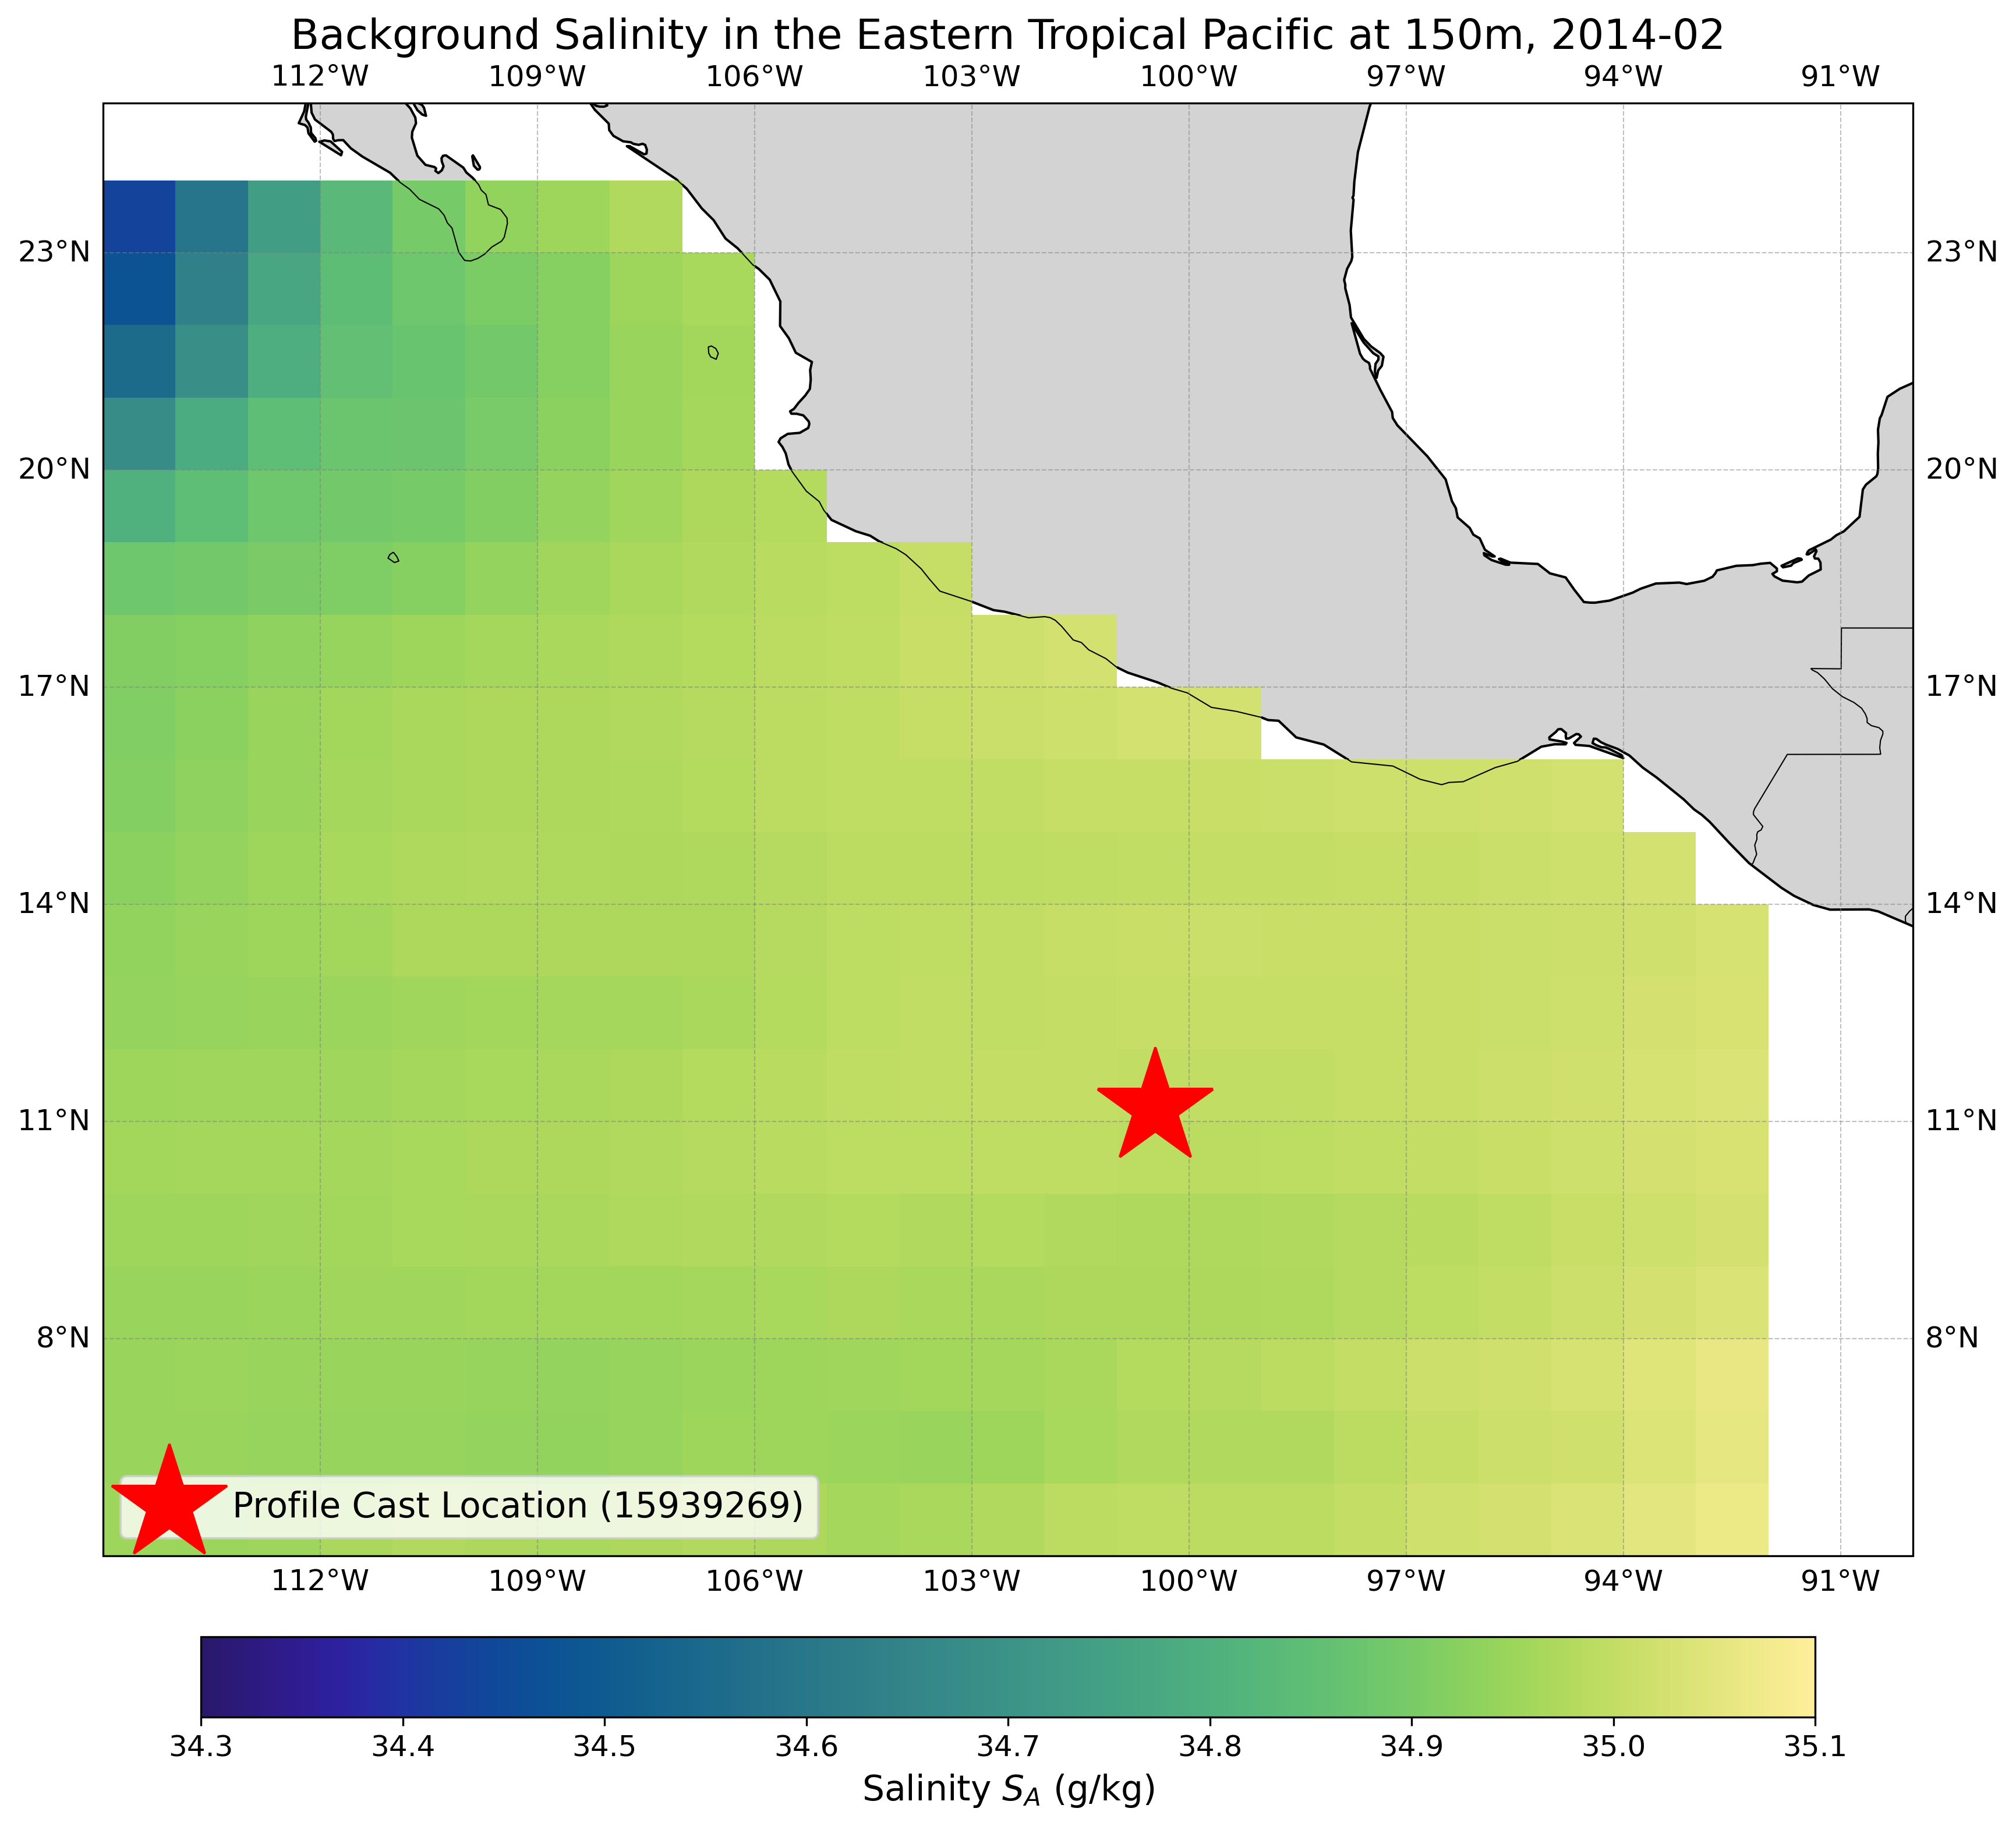

In [158]:
fig, ax = plt.subplots(
    figsize=(16, 12), dpi=300, facecolor='white',
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent([-115, -90, 5, 25])
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5,
    linestyle='--',
    xlocs=np.arange(-115, -90, 3),
    ylocs=np.arange(5, 25, 3)
)
gl.xlabel_style = {'size': 'large'}
gl.ylabel_style = {'size': 'large'}
ax.set_title(f'Background Salinity in the Eastern Tropical Pacific at 150m, {str(bkgSalinityGradient.TIME.values[121])[:7]}', fontsize='xx-large')
lon_grd, lat_grd = np.meshgrid(
    bkgSalinityGradient.LONGITUDE.values, bkgSalinityGradient.LATITUDE.values
)
quad = ax.pcolormesh(
    lon_grd, lat_grd, bkgSalinityGradient['SA'][15, :, :, 121],
    cmap=cmocean.cm.haline, vmin=34.3, vmax=35.1,
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(
    quad, ax=ax, orientation='horizontal', pad=0.05,
    aspect=20, fraction=0.05
)
cbar.ax.tick_params(labelsize='large')
cbar.set_label(r'Salinity $S_A$ (g/kg)', fontsize='x-large')
# Mark location of the cast
ax.plot(
    profileAnomalies['lon'].sel(casts=profileAnomalies['casts'].values[i]), profileAnomalies['lat'].sel(casts=profileAnomalies['casts'].values[i]),
    'r*', markersize=50, label=f'Profile Cast Location ({profileAnomalies["casts"].values[i]})'
)
ax.legend(loc='lower left', fontsize='x-large')
plt.savefig(f"../fig/etp_background_salinity_150m_cast{profileAnomalies['casts'].values[i]}.png", dpi=300, bbox_inches="tight")

In [162]:
sampleCast = initialProfileDataset.sel(
    casts=15939269
)

In [169]:
anomalyCast = profileAnomalies.sel(
    casts=15939269
)

In [164]:
sampleCast['eddy_track'].values

array(619295., dtype=float32)

In [230]:
castClimatology = bkgSalinityGradient.sel(
    LATITUDE=profileAnomalies['casts'][i].lat.values,
    LONGITUDE=360 + profileAnomalies['casts'][i].lon.values,
    method='nearest',
)
castClimatology = castClimatology.sel(
    TIME=slice(np.datetime64('2013-08-01'), np.datetime64('2014-07-31'))
)

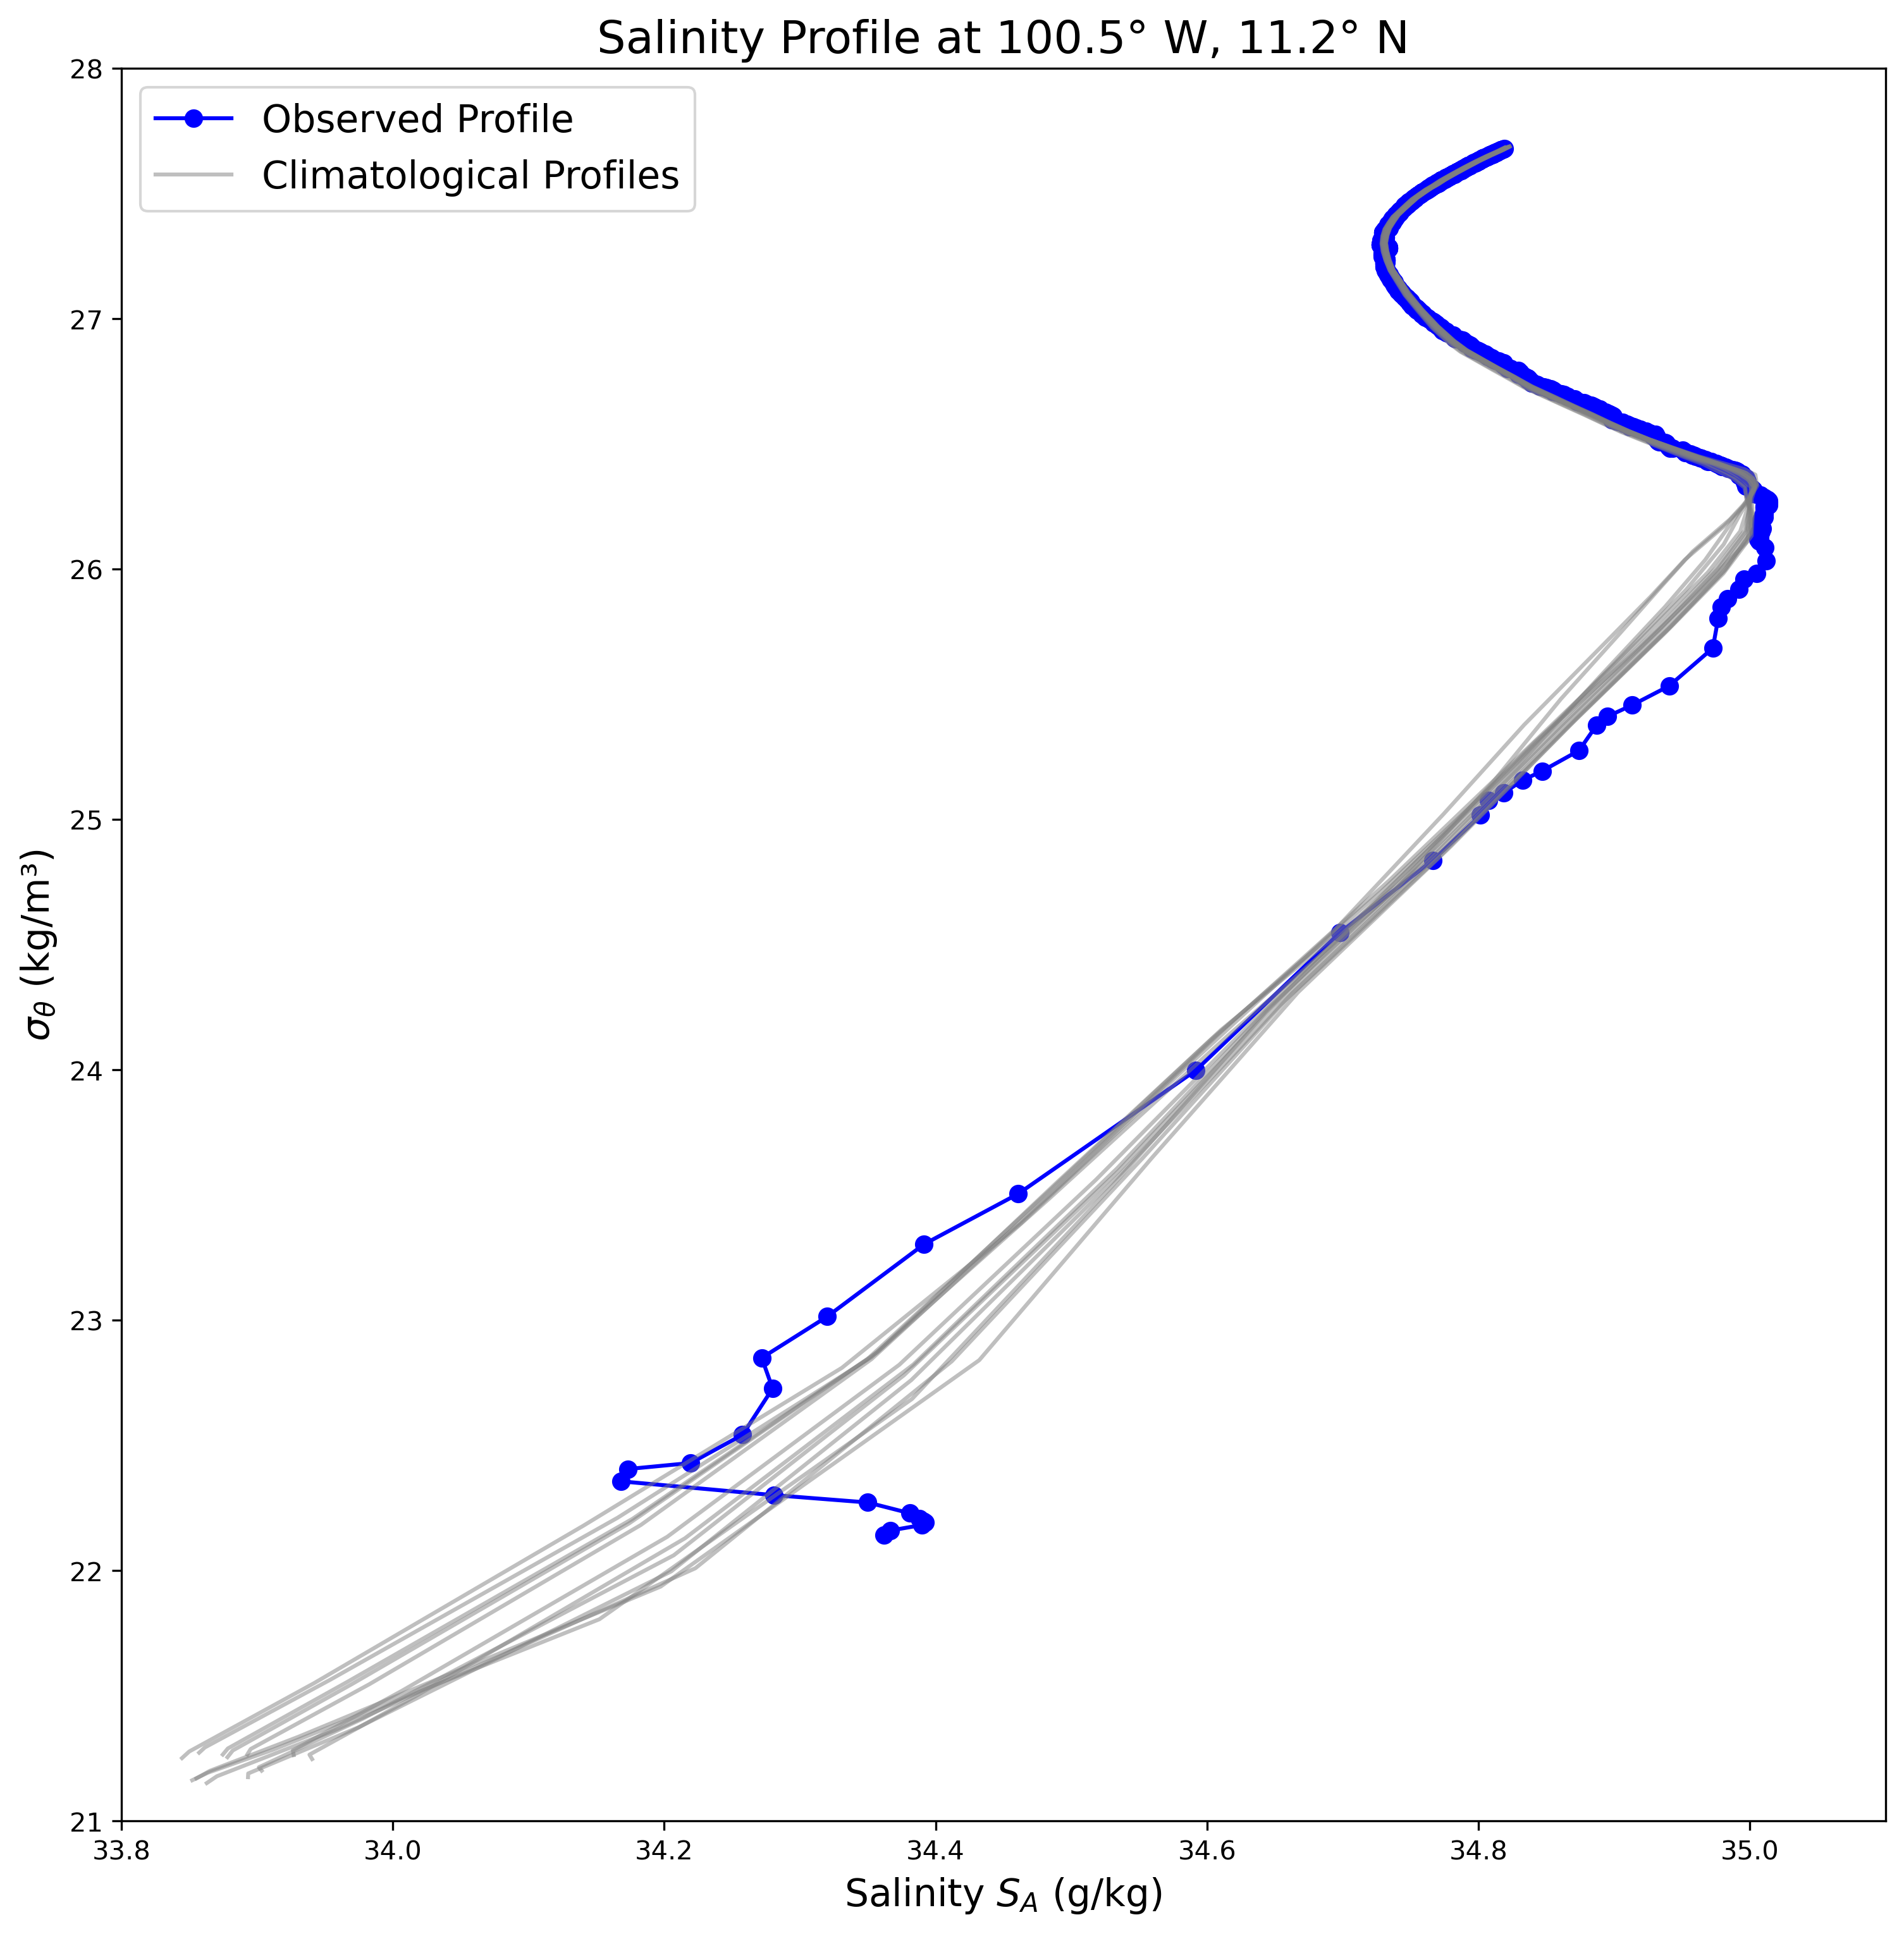

In [231]:
# Plot salinity profile and climatological background for cast time and location
fig, ax = plt.subplots(
    figsize=(12, 12), dpi=300, facecolor='white'
)
ax.set_title(f'Salinity Profile at {abs(sampleCast["lon"].values):.1f}° W, {sampleCast["lat"].values:.1f}° N', fontsize='xx-large')
ax.set_xlabel('Salinity $S_A$ (g/kg)', fontsize='x-large')
ax.set_ylabel(r'$\sigma_\theta$ (kg/m³)', fontsize='x-large')
ax.plot(
    anomalyCast['SA'], anomalyCast['sigma0'],
    'o-', label='Observed Profile', color='blue'
)
for time in castClimatology.TIME.values:
    ax.plot(
        castClimatology['SA'].sel(TIME=time), castClimatology['sigma0'].sel(TIME=time),
        '-', color='gray', alpha=0.5, label='Climatological Profiles' if time == castClimatology.TIME.values[0] else ""
    )
ax.set_xlim(33.8, 35.1)
ax.set_ylim(21, 28)
ax.legend(fontsize='x-large')
plt.savefig(f"../fig/cast{sampleCast['casts'].values}_salinity_profile_climatology.png", dpi=300, bbox_inches="tight")

In [212]:
sampleCast['eddy_rotation'].values

array(1., dtype=float32)

In [213]:
longCyclones = longCyclones[['latitude', 'longitude', 'track', 'time',]]

In [214]:
eddy = longCyclones.where(
    longCyclones['track'] == 619295,
    drop=True
)

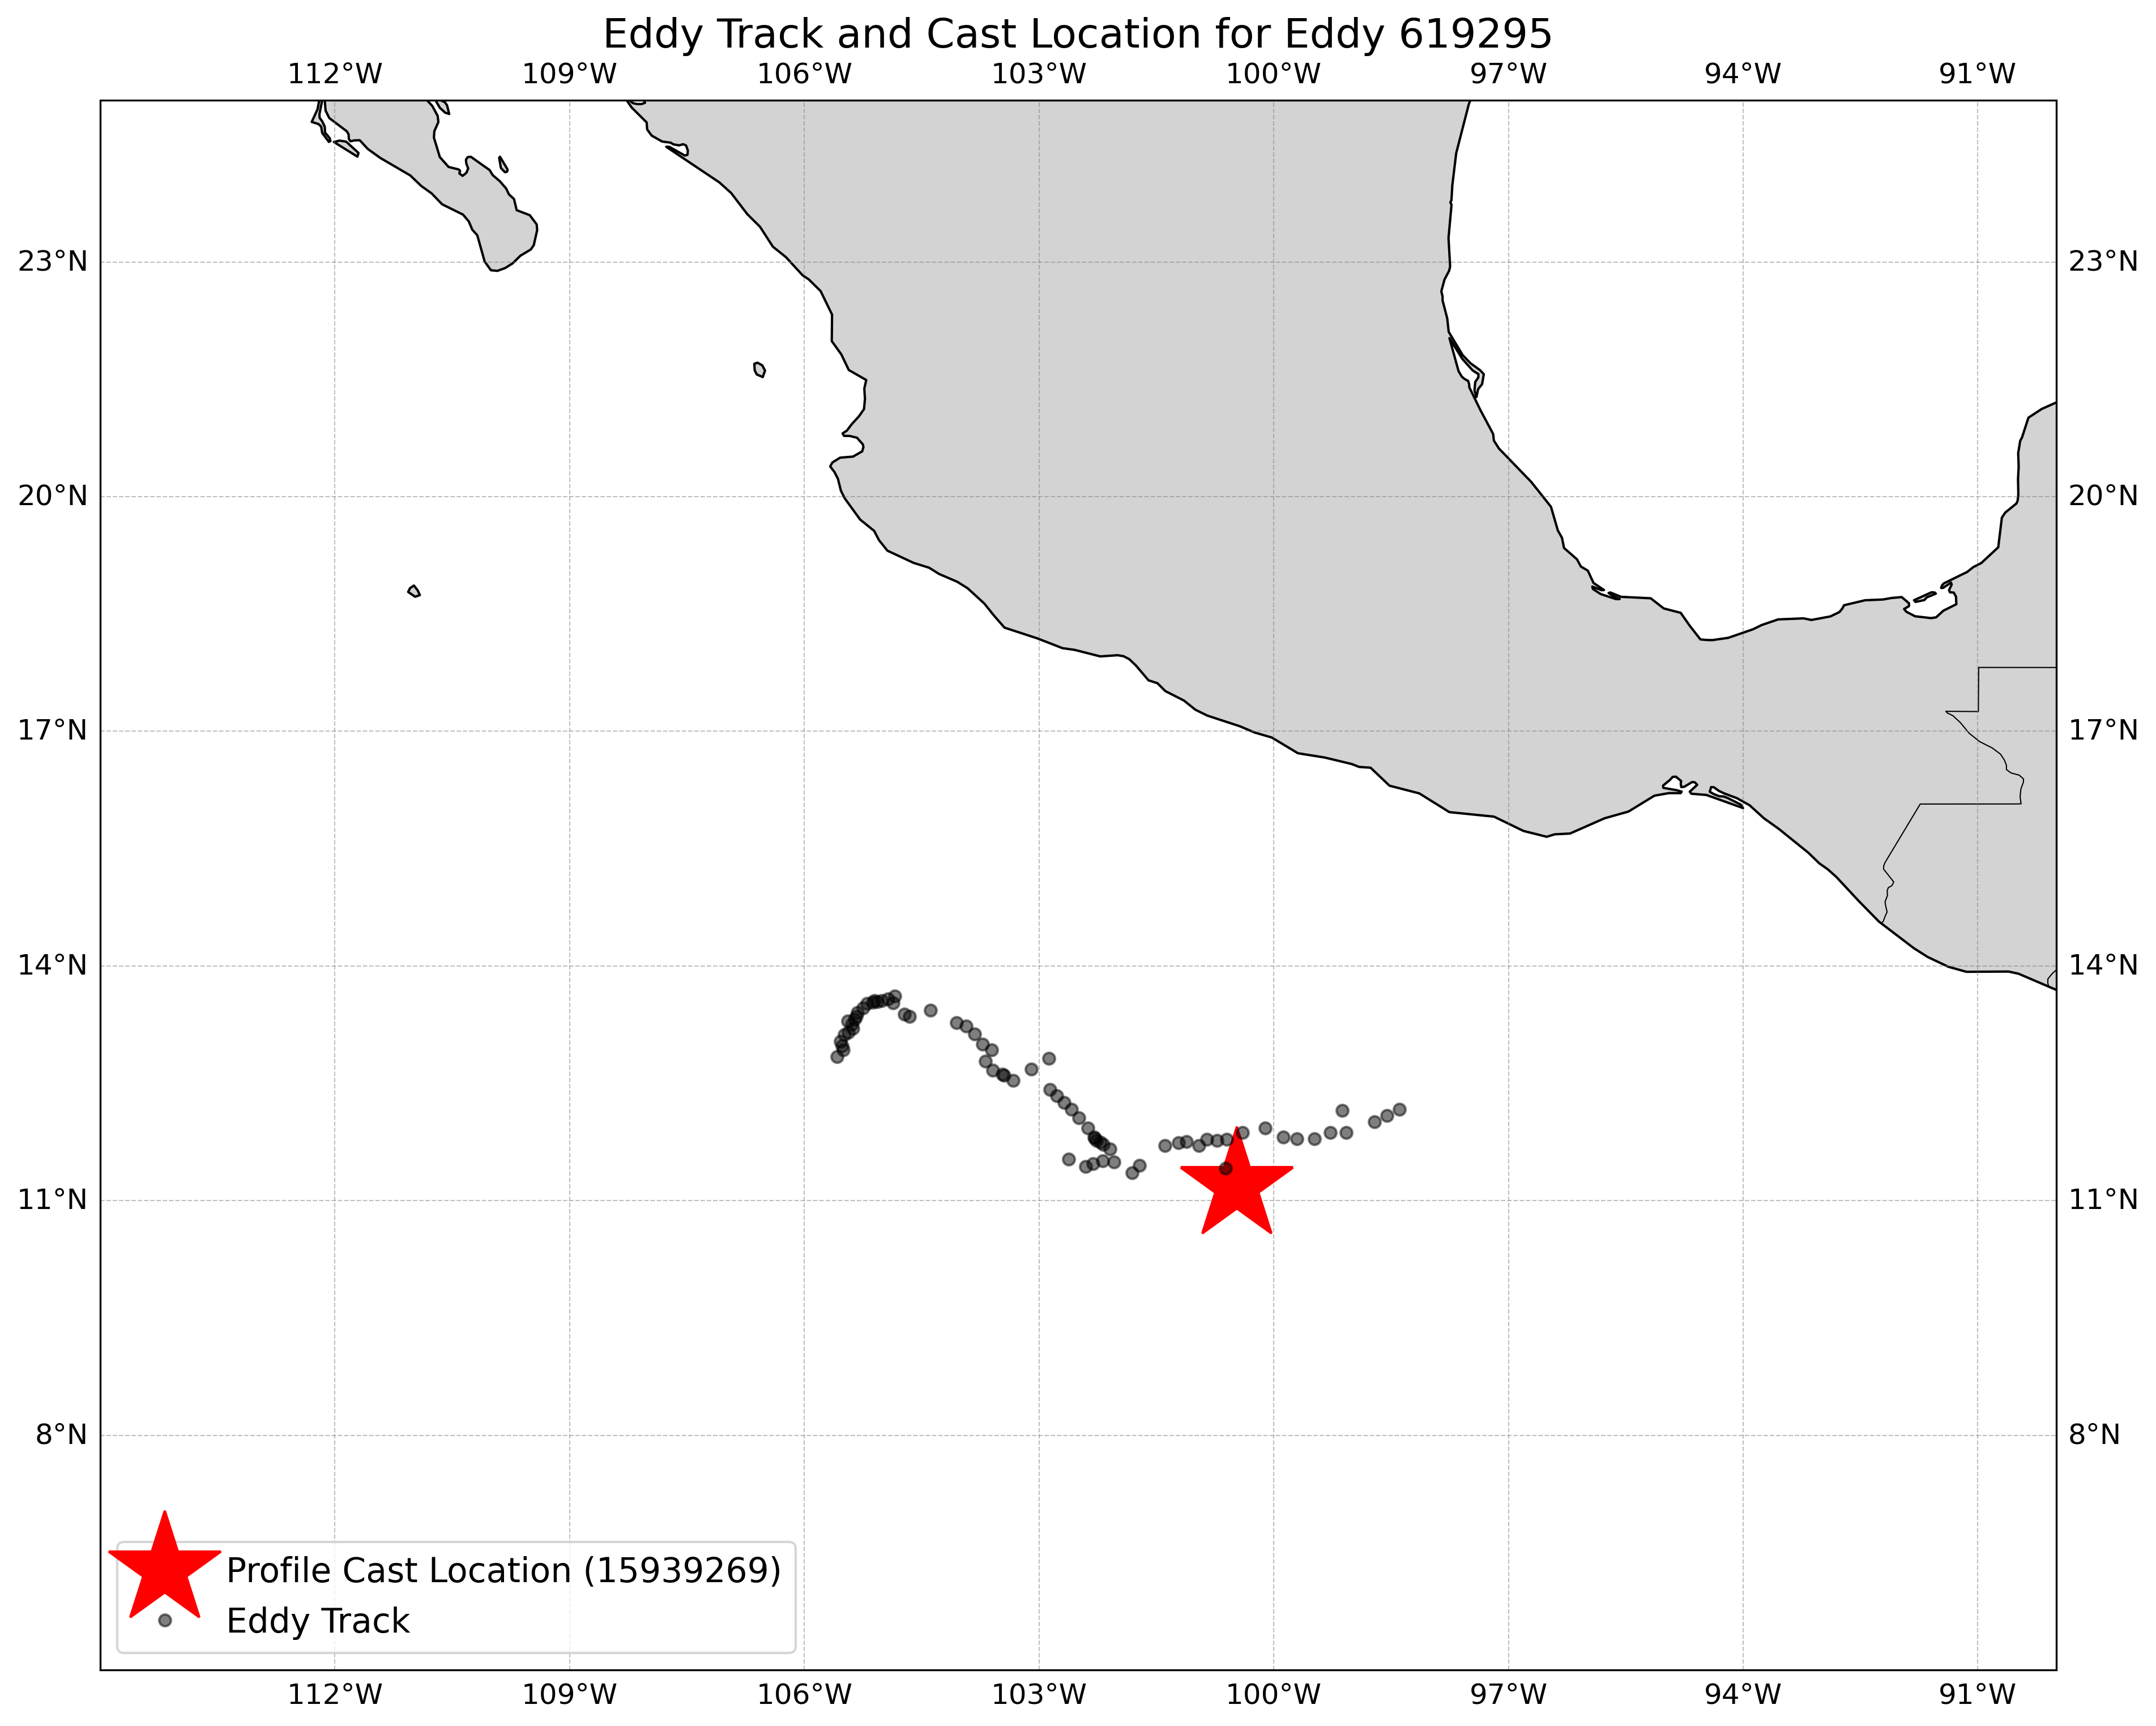

In [223]:
# Cast location and eddy track plot
fig, ax = plt.subplots(
    figsize=(16, 12), dpi=300, facecolor='white',
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent([-115, -90, 5, 25])
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")
gls = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5,
    linestyle='--',
    xlocs=np.arange(-115, -90, 3),
    ylocs=np.arange(5, 25, 3)
)
gls.xlabel_style = {'size': 'large'}
gls.ylabel_style = {'size': 'large'}
ax.set_title(f'Eddy Track and Cast Location for Eddy 619295', fontsize='xx-large')
# Mark location of the cast
ax.plot(
    profileAnomalies['lon'].sel(casts=profileAnomalies['casts'].values[i]), 
    profileAnomalies['lat'].sel(casts=profileAnomalies['casts'].values[i]),
    'r*', markersize=50, label=f'Profile Cast Location ({profileAnomalies["casts"].values[i]})'
)
# Plot the eddy center
for values in eddy['obs'].values:
    ax.plot(
        eddy['longitude'].sel(obs=values), 
        eddy['latitude'].sel(obs=values),
        'ko', markersize=5, alpha=0.5, label='Eddy Track' if values == eddy['obs'].values[0] else "",
        transform=ccrs.PlateCarree()
    )
# Add legend
ax.legend(loc='lower left', fontsize='x-large')
plt.savefig(f"../fig/eddy_track_cast{profileAnomalies['casts'].values[i]}_619295.png", dpi=300, bbox_inches="tight")

In [224]:
castClimatology = bkgSalinityGradient.sel(
    LATITUDE=eddy.latitude.values[0],
    LONGITUDE=360 + eddy.longitude.values[0],
    method='nearest',
)
castClimatology = castClimatology.sel(
    TIME=slice(np.datetime64('2013-08-01'), np.datetime64('2014-07-31'))
)

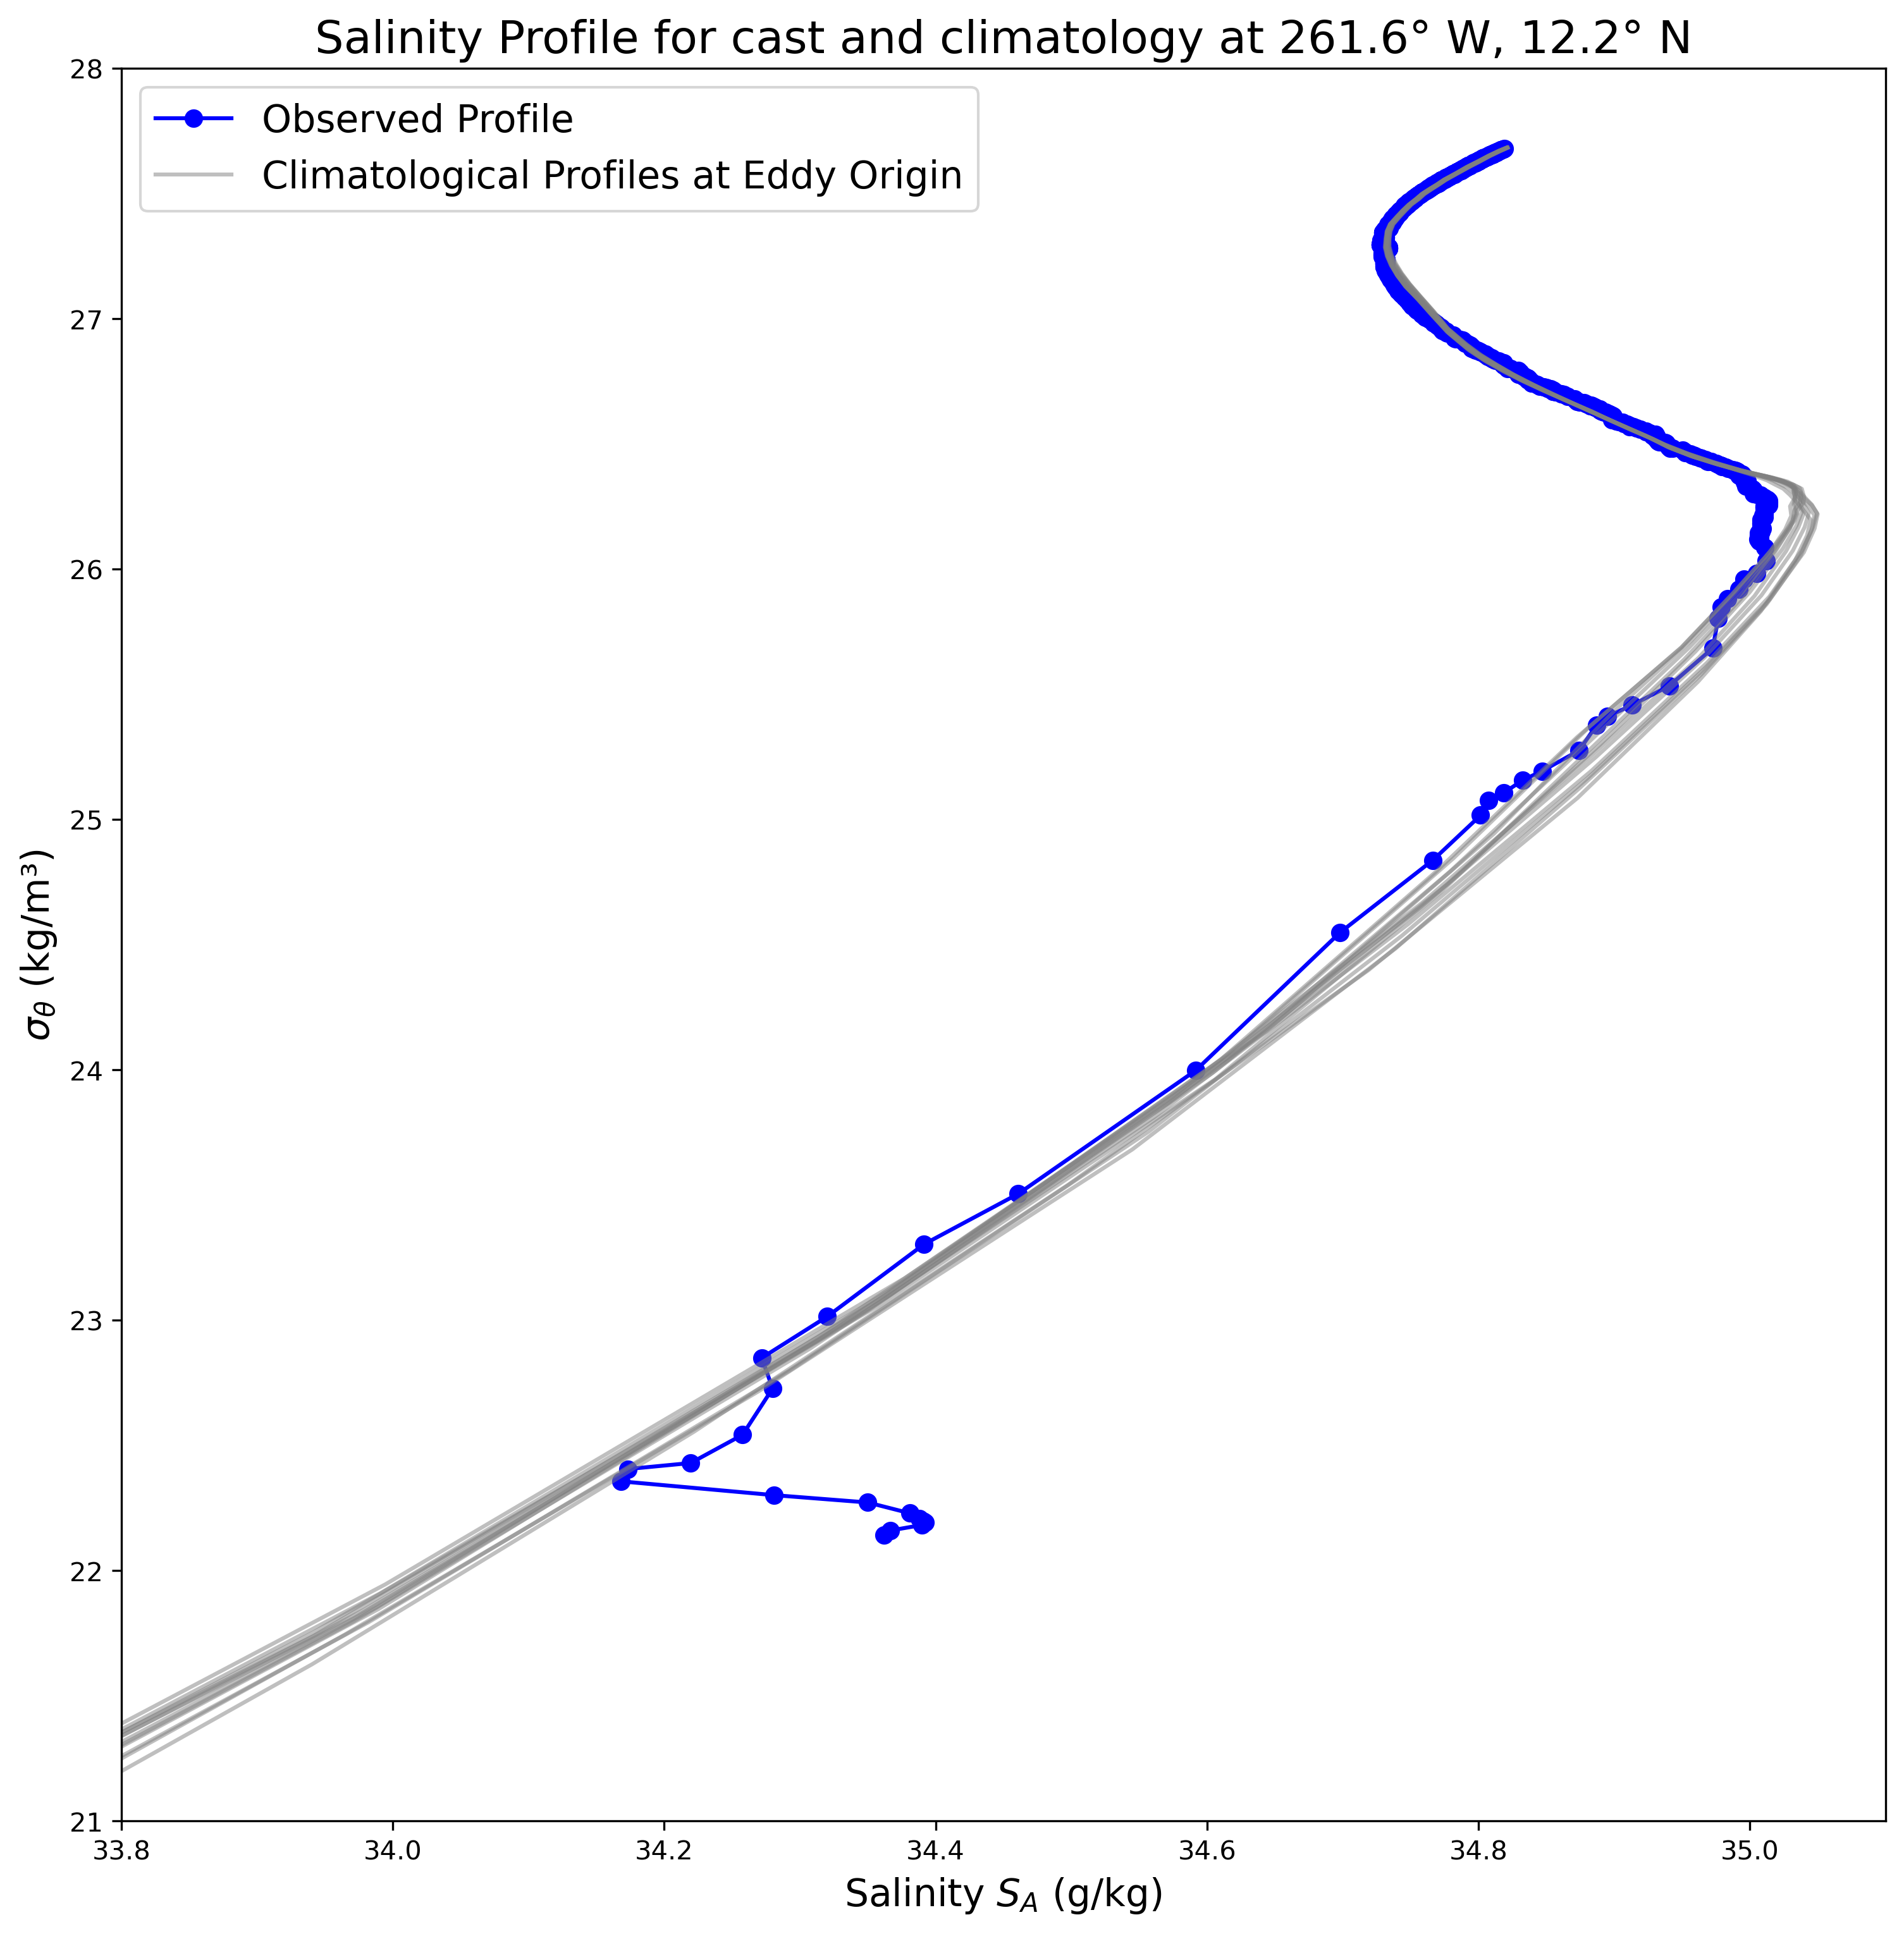

In [ ]:
# Plot salinity profile and climatological background for cast time and eddy origin location
fig, ax = plt.subplots(
    figsize=(12, 12), dpi=300, facecolor='white'
)
ax.set_title(f'Salinity Profile for cast and climatology at {360 - abs(eddy.longitude.values[0]):.1f}° W, {eddy.latitude.values[0]:.1f}° N', fontsize='xx-large')
ax.set_xlabel('Salinity $S_A$ (g/kg)', fontsize='x-large')
ax.set_ylabel(r'$\sigma_\theta$ (kg/m³)', fontsize='x-large')
ax.plot(
    anomalyCast['SA'], anomalyCast['sigma0'],
    'o-', label='Observed Profile', color='blue'
)
for time in castClimatology.TIME.values:
    ax.plot(
        castClimatology['SA'].sel(TIME=time), castClimatology['sigma0'].sel(TIME=time),
        '-', color='gray', alpha=0.5, label='Climatological Profiles at Eddy Origin' if time == castClimatology.TIME.values[0] else ""
    )
ax.set_xlim(33.8, 35.1)
ax.set_ylim(21, 28)
ax.legend(fontsize='x-large')
plt.savefig(f"../fig/cast{sampleCast['casts'].values}_salinity_profile_eddy_climatology.png", dpi=300, bbox_inches="tight")

In [ ]:
castLoc = bkgSalinityGradient.sel(
    LATITUDE=profileAnomalies['casts'][i].lat.values,
    LONGITUDE=360 + profileAnomalies['casts'][i].lon.values,
    TIME=np.datetime64('2014-02-01'),
    method='nearest'
)

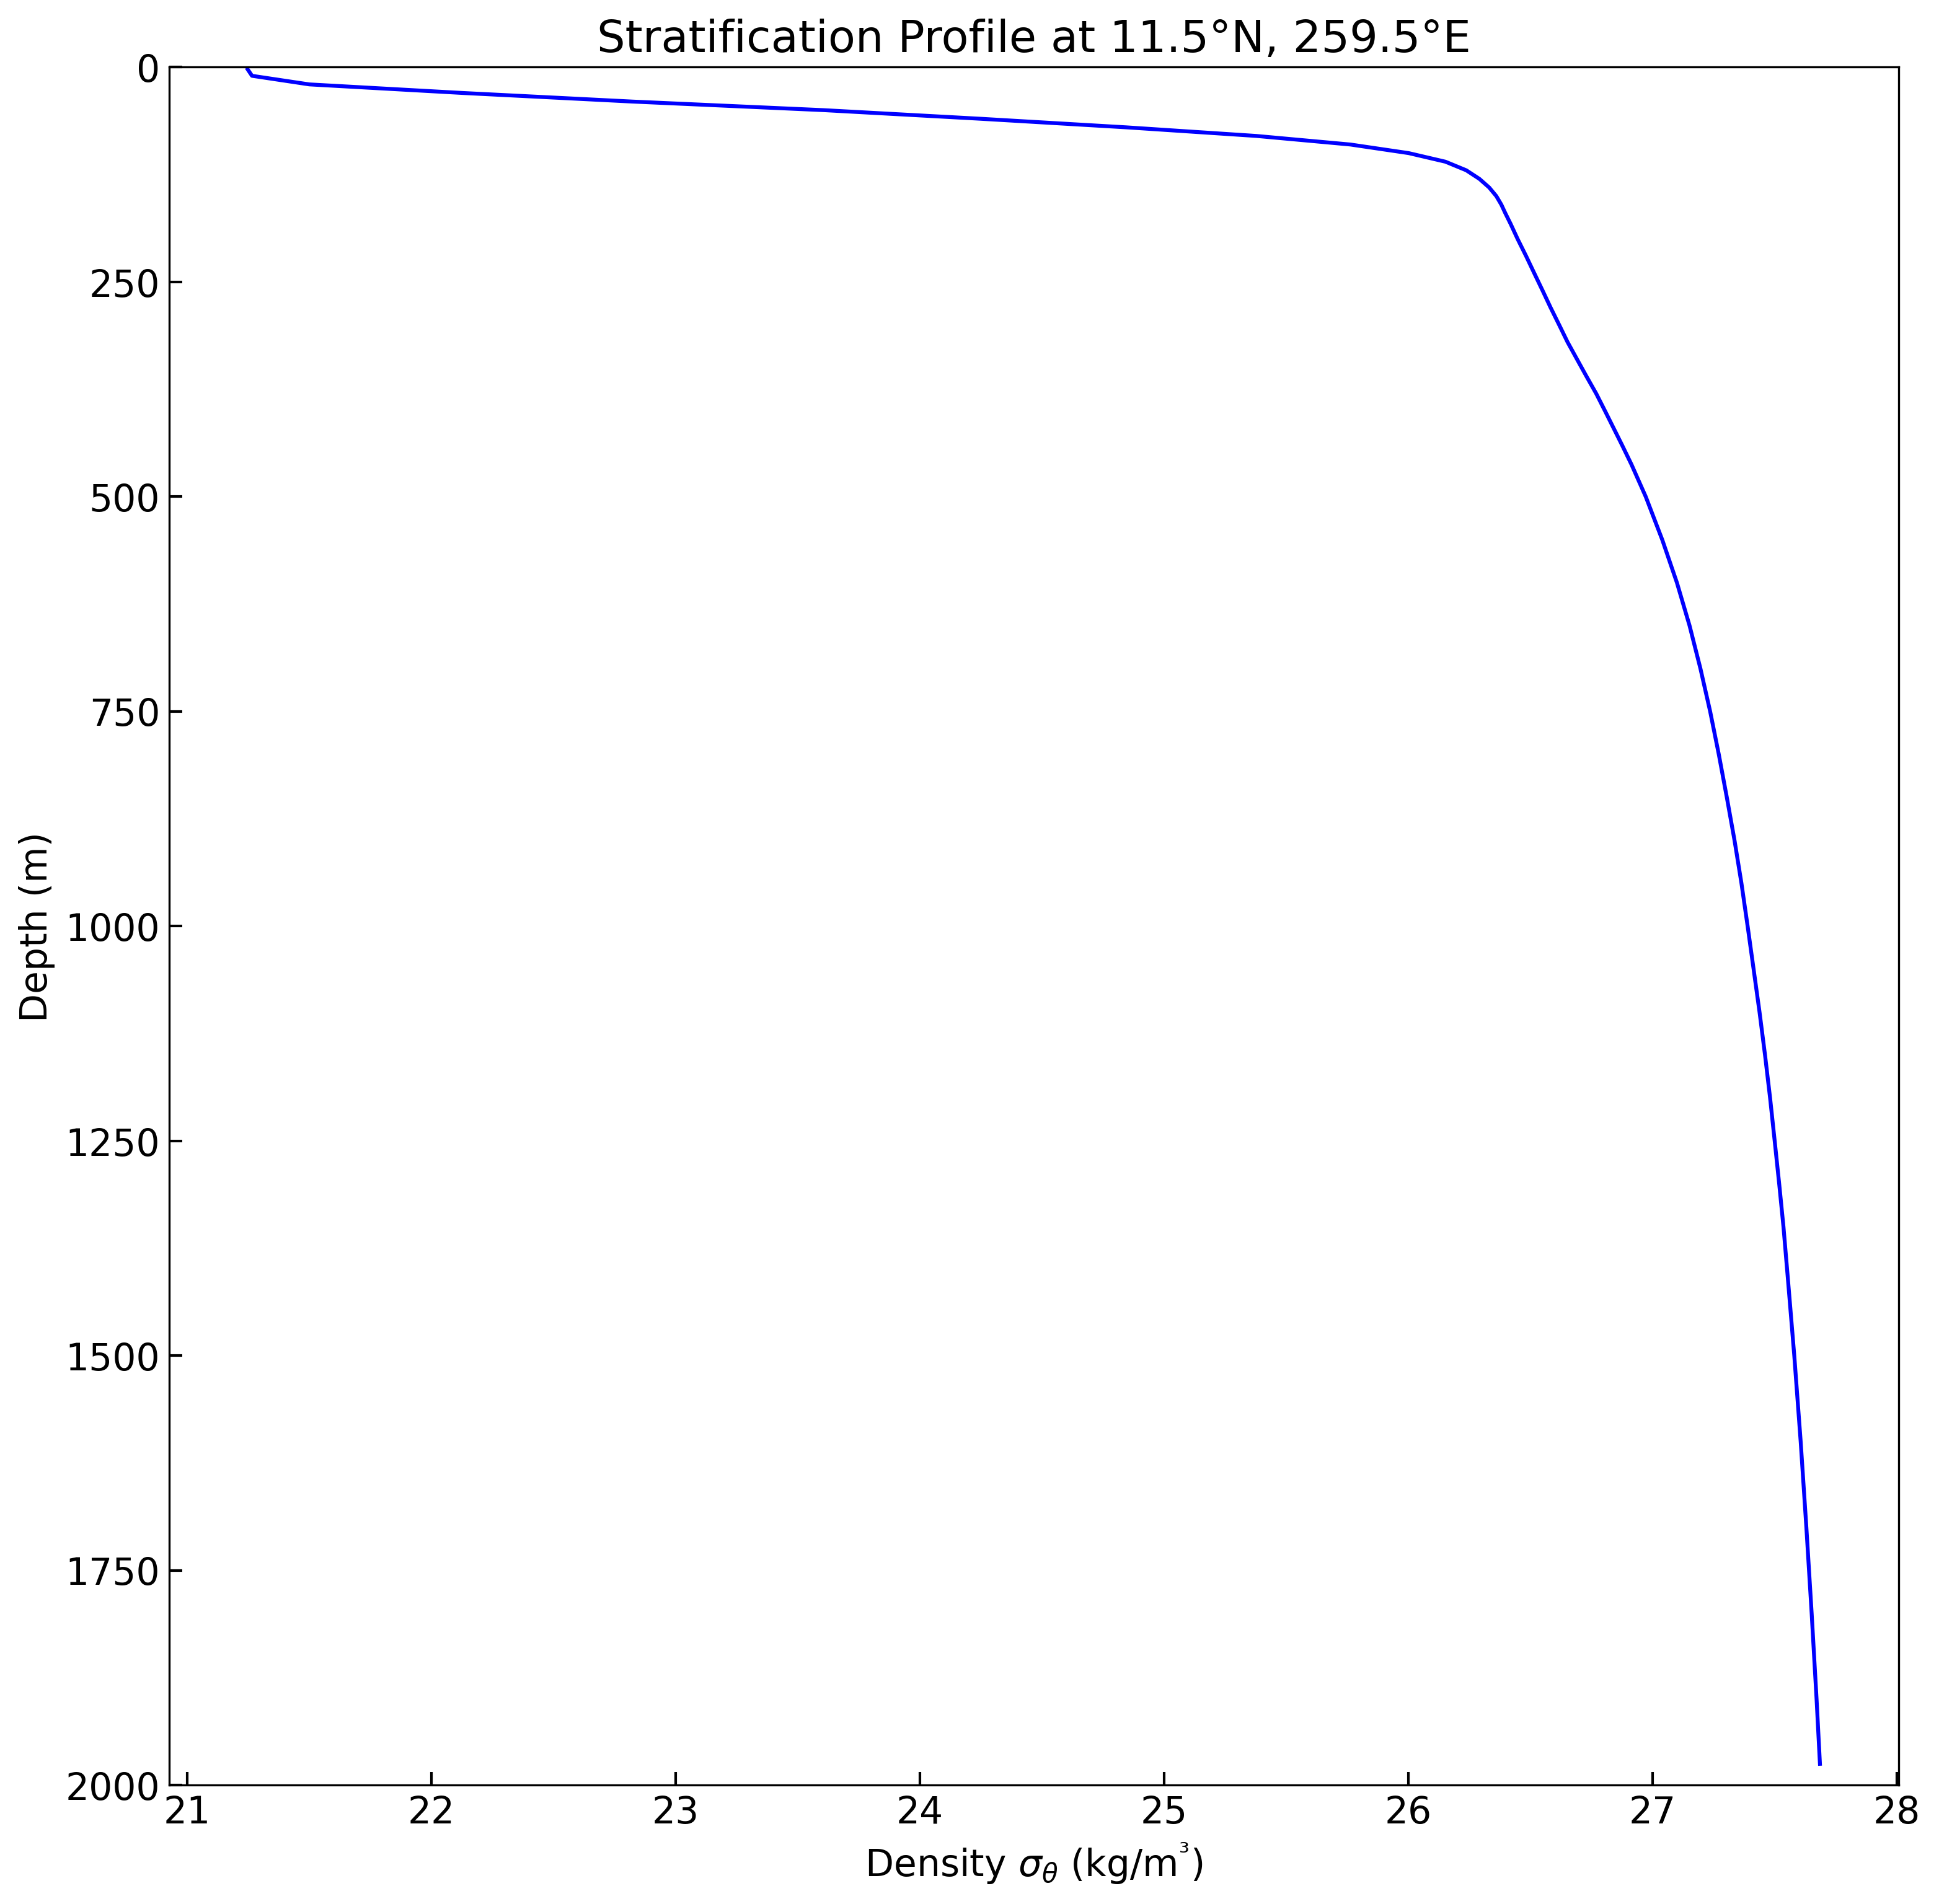

In [160]:
# Stratification Profile
fig, ax = plt.subplots(
    figsize=(12, 12), dpi=300, facecolor='white',
)
ax.set_title('Stratification Profile at ' + str(castLoc['LATITUDE'].values) + '°N, ' + str(castLoc['LONGITUDE'].values) + '°E', fontsize='xx-large')
ax.set_xlabel(r'Density $\sigma_\theta$ (kg/m$^³$)', fontsize='x-large')
ax.set_ylabel(r'Depth (m)', fontsize='x-large')
ax.plot(
    castLoc['sigma0'],
    castLoc['PRESSURE'],
    label='Stratification Profile',
    color='blue'
)
ax.set_ylim(0, 2000)
ax.tick_params(
    which='both', labelsize='x-large', direction='in', length=5, width=1
)
plt.gca().invert_yaxis()  # Invert y-axis for depth profile
plt.savefig(
    'stratification_profile_' + str(castLoc['LATITUDE'].values) + 'N_' + str(castLoc['LONGITUDE'].values) + 'E.png',
    bbox_inches='tight'
)

In [ ]:
density = 27.0

In [ ]:
lonBins = np.arange(-114.25, -94.75, 1.5)
latBins = np.arange(5.75, 22.25, 1.5)
binCenters = [lonBins, latBins]
binSize = 1.5

In [ ]:
fig, axs = plt.subplots(
    2, 2, figsize=(14, 12),
    subplot_kw={'projection': ccrs.PlateCarree()},
    sharex=True, sharey=True
)
axs = axs.flatten()
for ax in axs:
    ax.set_extent([-115, -91, 5, 24], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.gridlines(
        draw_labels=True, linewidth=0.5,
        color='gray', alpha=0.5, linestyle='--',
        xlocs=np.arange(-115, -94, 1.5),
        ylocs=np.arange(5, 23, 1.5)
    )

axs[0].set_title("Mean Salinity")
sal = meanSalinity.plot.imshow(
    x='lon', y='lat',
    ax=axs[0], cmap=cmocean.cm.haline,
    cbar_kwargs={'orientation': 'horizontal', 'pad': 0.1,
                 'label': r'$\langle \{ \text{S} \} \rangle (\text{g kg}^{-1})$',
                 'aspect': 20, 'fraction': 0.05}
)
axs[2].set_title("Mean Salinity Gradient")
grad = meanSalinityGradient.plot.imshow(
    x='lon', y='lat',
    ax=axs[2], cmap=cmocean.cm.tempo,
    cbar_kwargs={'orientation': 'horizontal', 'pad': 0.1,
                 'label': r'$\langle \nabla \{ \text{S} \} \rangle (\text{g kg}^{-1} \text{km}^{-1})$',
                 'format': mticker.FuncFormatter(fmt),
                 'aspect': 20, 'fraction': 0.05}
)
axs[1].set_title("RMS Salinity Anomaly")
salAnomaly = binnedAnomalies.plot.imshow(
    x='lon', y='lat',
    ax=axs[1], vmin=0, cmap=cmocean.cm.matter,
    cbar_kwargs={'orientation': 'horizontal', 'pad': 0.1,
                 'label': r'$\langle \{ S^\prime S^\prime \} \rangle^{0.5} (\text{g kg}^{-1})$',
                 'aspect': 20, 'fraction': 0.05}
)
axs[3].set_title("Mixing Length")
mixLength = mixingLength.plot.imshow(
    x='lon', y='lat',
    ax=axs[3], cmap=cmocean.cm.amp, vmin=0, vmax=300,
    cbar_kwargs={'orientation': 'horizontal', 'pad': 0.1,
                 'label': r'$\lambda (\text{km})$',
                 'aspect': 20, 'fraction': 0.05}
)

fig.suptitle("Statistics on the 27.0 kg/m³ Isopycnal - Full Temporal Average", fontsize=16)
plt.savefig("../fig/27kg_m3_statistics.png", dpi=300, bbox_inches='tight')


In [ ]:
density = 25.0
fig, axs = plt.subplots(
    2, 2, figsize=(14, 12),
    subplot_kw={'projection': ccrs.PlateCarree()},
    sharex=True, sharey=True
)
axs = axs.flatten()
plotMap(
    profileAnomalies,
    bkgSalinityGradient,
    density=density,
    binCenters=binCenters,
    fig=fig,
    axs=axs,
)
fig.suptitle("Statistics on the 25.0 kg/m³ Isopycnal - Full Temporal Average", fontsize=16)
plt.savefig(f"../fig/{density:.1f}kg_m3_statistics_map.png", dpi=300, bbox_inches='tight')

In [ ]:
lonBins = np.arange(-113.75, -95.25, 2.5)
latBins = np.arange(6.25, 21.75, 2.5)
binCenters = [lonBins, latBins]
binSize = 2.5

In [ ]:
jfmProfileAnomalies = profileAnomalies.where(
    (profileAnomalies['time.month'] == 1) |
    (profileAnomalies['time.month'] == 2) |
    (profileAnomalies['time.month'] == 3),
    drop=True
)
jfmClimatology = bkgSalinityGradient.where(
    (bkgSalinityGradient['TIME.month'] == 1) |
    (bkgSalinityGradient['TIME.month'] == 2) |
    (bkgSalinityGradient['TIME.month'] == 3),
    drop=True
)
amjProfileAnomalies = profileAnomalies.where(
    (profileAnomalies['time.month'] == 4) |
    (profileAnomalies['time.month'] == 5) |
    (profileAnomalies['time.month'] == 6),
    drop=True
)
amjClimatology = bkgSalinityGradient.where(
    (bkgSalinityGradient['TIME.month'] == 4) |
    (bkgSalinityGradient['TIME.month'] == 5) |
    (bkgSalinityGradient['TIME.month'] == 6),
    drop=True
)
jasProfileAnomalies = profileAnomalies.where(
    (profileAnomalies['time.month'] == 7) |
    (profileAnomalies['time.month'] == 8) |
    (profileAnomalies['time.month'] == 9),
    drop=True
)
jasClimatology = bkgSalinityGradient.where(
    (bkgSalinityGradient['TIME.month'] == 7) |
    (bkgSalinityGradient['TIME.month'] == 8) |
    (bkgSalinityGradient['TIME.month'] == 9),
    drop=True
)
ondProfileAnomalies = profileAnomalies.where(
    (profileAnomalies['time.month'] == 10) |
    (profileAnomalies['time.month'] == 11) |
    (profileAnomalies['time.month'] == 12),
    drop=True
)
ondClimatology = bkgSalinityGradient.where(
    (bkgSalinityGradient['TIME.month'] == 10) |
    (bkgSalinityGradient['TIME.month'] == 11) |
    (bkgSalinityGradient['TIME.month'] == 12),
    drop=True
)

In [ ]:
seasonalAnomalies = {
    'JFM': jfmProfileAnomalies,
    'AMJ': amjProfileAnomalies,
    'JAS': jasProfileAnomalies,
    'OND': ondProfileAnomalies
}
seasonalClimatology = {
    'JFM': jfmClimatology,
    'AMJ': amjClimatology,
    'JAS': jasClimatology,
    'OND': ondClimatology
}
seasonal_labels = {
    'JFM': 'January-February-March',
    'AMJ': 'April-May-June',
    'JAS': 'July-August-September',
    'OND': 'October-November-December'
}

In [ ]:
density = 25.0
salinity_lims = (34.1, 34.9)
grad_lims = (0, 1.2E-3)
anomaly_lims = (0, 0.35)
lambda_lims = (0, 800)
for season, anomalies in seasonalAnomalies.items():
    climatology = seasonalClimatology[season]
    fig, axs = plt.subplots(
        2, 2, figsize=(14, 12),
        subplot_kw={'projection': ccrs.PlateCarree()},
        sharex=True, sharey=True
    )
    axs = axs.flatten()
    plotMap(
        anomalies,
        climatology,
        density=density,
        binCenters=binCenters,
        fig=fig,
        axs=axs,
        salinity_lims=salinity_lims,
        grad_lims=grad_lims,
        anomaly_lims=anomaly_lims,
        lambda_lims=lambda_lims
    )
    fig.suptitle(f"Statistics on the {density:.1f} kg/m³ Isopycnal - {seasonal_labels[season]} Average", fontsize=16)
    plt.savefig(f"../fig/{density:.1f}kg_m3__{season}_statistics_map.png", dpi=300, bbox_inches='tight')

In [ ]:
highWindAnomalies = profileAnomalies.where(
    np.logical_or(
        profileAnomalies['time.dayofyear'] <= 70,
        profileAnomalies['time.dayofyear'] >= 340
    ),
    drop=True
)
highWindClimatology = bkgSalinityGradient.where(
    np.logical_or(
        (bkgSalinityGradient['TIME.dayofyear'] <= 70),
        (bkgSalinityGradient['TIME.dayofyear'] >= 340)
    ),
    drop=True
)
lowWindAnomalies = profileAnomalies.where(
    np.logical_and(
        profileAnomalies['time.dayofyear'] > 140,
        profileAnomalies['time.dayofyear'] < 300
    ),
    drop=True
)
lowWindClimatology = bkgSalinityGradient.where(
    np.logical_and(
        bkgSalinityGradient['TIME.dayofyear'] > 140,
        bkgSalinityGradient['TIME.dayofyear'] < 300
    ),
    drop=True
)

In [ ]:
seasonalAnomalies = {
    'High-Winds': highWindAnomalies,
    'Low-Winds': lowWindAnomalies
}
seasonalClimatology = {
    'High-Winds': highWindClimatology,
    'Low-Winds': lowWindClimatology
}
seasonalLabels = {
    'High-Winds': 'High Wind Season',
    'Low-Winds': 'Low Wind Season'
}

In [ ]:
plotLims = {
    25.0: {
        'salinity': (34.1, 34.9),
        'gradient': (0, 1.2E-3),
        'anomaly': (0, 0.35),
        'mixing_length': (0, 800)
    },
    26.0: {
        'salinity': (34.5, 35.0),
        'gradient': (0, 1.2E-3),
        'anomaly': (0, 0.18),
        'mixing_length': (0, 800)
    },
    27.0: {
        'salinity': (34.65, 34.8),
        'gradient': (0, 1.5E-4),
        'anomaly': (0, 0.03),
        'mixing_length': (0, 600)
    }
}

In [ ]:
density = 27.0
for season, anomalies in seasonalAnomalies.items():
    climatology = seasonalClimatology[season]
    fig, axs = plt.subplots(
        2, 2, figsize=(14, 12),
        subplot_kw={'projection': ccrs.PlateCarree()},
        sharex=True, sharey=True
    )
    axs = axs.flatten()
    plotMap(
        anomalies,
        climatology,
        density=density,
        binCenters=binCenters,
        fig=fig,
        axs=axs,
        salinity_lims=plotLims[density]['salinity'],
        grad_lims=plotLims[density]['gradient'],
        anomaly_lims=plotLims[density]['anomaly'],
        lambda_lims=plotLims[density]['mixing_length']
    )
    fig.suptitle(f"Statistics on the {density:.1f} kg/m³ Isopycnal - {seasonalLabels[season]} Average", fontsize=16)
    plt.savefig(f"../fig/{density:.1f}kg_m3__{season}_statistics_map.png", dpi=300, bbox_inches='tight')

In [ ]:
profileMLD = climatologicalMLD[['mld_da_mean', 'mld_da_max', 'mld_dt_mean', 'mld_dt_max']].sel(
    iLAT=minimalProfileData['lat'],
    iLON=minimalProfileData['lon'],
    iMONTH=minimalProfileData['time.month'],
    method='nearest'
)
profileMLD['casts'] = ("casts", minimalProfileData['casts'].data)

In [ ]:
fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(10, 8)
)
plt.scatter(
    profileMLD['lon'], profileMLD['lat'],
    c=profileMLD['mld_da_max'].data, cmap='viridis',
    s=0.2
)
plt.colorbar(label='Mixed Layer Depth (m)', pad=0.08)
plt.title('Maximum Climatological MLD at Profile Locations and Months')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.savefig('../fig/ARGO_climMLD_ProfileLocations_Months.png', dpi=300, bbox_inches='tight')

In [ ]:
lat_range = (12.5, 14)
lon_range = (-110, -108.5)

sampleBinAnomalies = subset(
    profileAnomalies,
    lat_range=lat_range,
    lon_range=lon_range,
    var_names=['lat', 'lon', 'time']
)

In [ ]:
sigma0_bins = np.arange(24, 28, 0.2)
sampleBinAnomalies['SA_anomaly_squared'] = np.abs(sampleBinAnomalies['SA_anomaly'])**2
groupedAnomalies = sampleBinAnomalies.groupby_bins(
    'sigma0', sigma0_bins, labels=sigma0_bins[:-1]
).mean(skipna=True)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(
    np.abs(sampleBinAnomalies['SA_anomaly'].where(sampleBinAnomalies['sigma0'] > 24).data), sampleBinAnomalies['sigma0'].where(sampleBinAnomalies['sigma0'] > 24).data,
    color='black', s=0.4, marker='o'
)
plt.plot(
    np.sqrt(groupedAnomalies['SA_anomaly_squared'].data), groupedAnomalies['sigma0_bins'].data,
    linestyle='-', color='red', label=r'$\langle S^\prime S^\prime \rangle^{1/2}$',
    linewidth=4
)
plt.xlabel(r'Absolute Salinity Anomaly $|S^\prime| = |S - \{S\}|$')
plt.ylabel(r'$\sigma_\theta$')
plt.title(f'Salinity Anomalies in Sample Bin - {lat_range[0]}°N to {lat_range[1]}°N, {lon_range[0]}°W to {lon_range[1]}°W')
# Reverse y-axis
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [2]:
month="07"
year="2013"
uvel, vvel = xr.open_dataset(
    "../data/ECCO2_StateEstimate//UVEL/UVEL.1440x720x50.201307.nc"
), xr.open_dataset(
    "../data/ECCO2_StateEstimate/VVEL/VVEL.1440x720x50.201307.nc"
)

In [7]:
uvel = uvel.sel(
    LATITUDE_T = slice(5, 23.75),
    LONGITUDE_T = slice(245, 267.5),
    drop=True
)
vvel = vvel.sel(
    LATITUDE_T = slice(5, 23.75),
    LONGITUDE_T = slice(245, 267.5),
    drop=True
)

In [34]:
vel = xr.merge([uvel, vvel])

In [42]:
vel['UVEL'][0, 0, :, :]

<xarray.DataArray 'UVEL' (LATITUDE_T: 75, LONGITUDE_T: 90)> Size: 27kB
[6750 values with dtype=float32]
Coordinates:
    DEPTH_T      float32 4B 5.0
  * LATITUDE_T   (LATITUDE_T) float32 300B 5.125 5.375 5.625 ... 23.38 23.62
  * LONGITUDE_T  (LONGITUDE_T) float32 360B 245.1 245.4 245.6 ... 267.1 267.4
    TIME         datetime64[ns] 8B 2013-07-16
Attributes:
    units:                         m/s
    long_name:                     zonal velocity
    FillValue:                     -9.9999998e+22
    number_of_significant_digits:  7

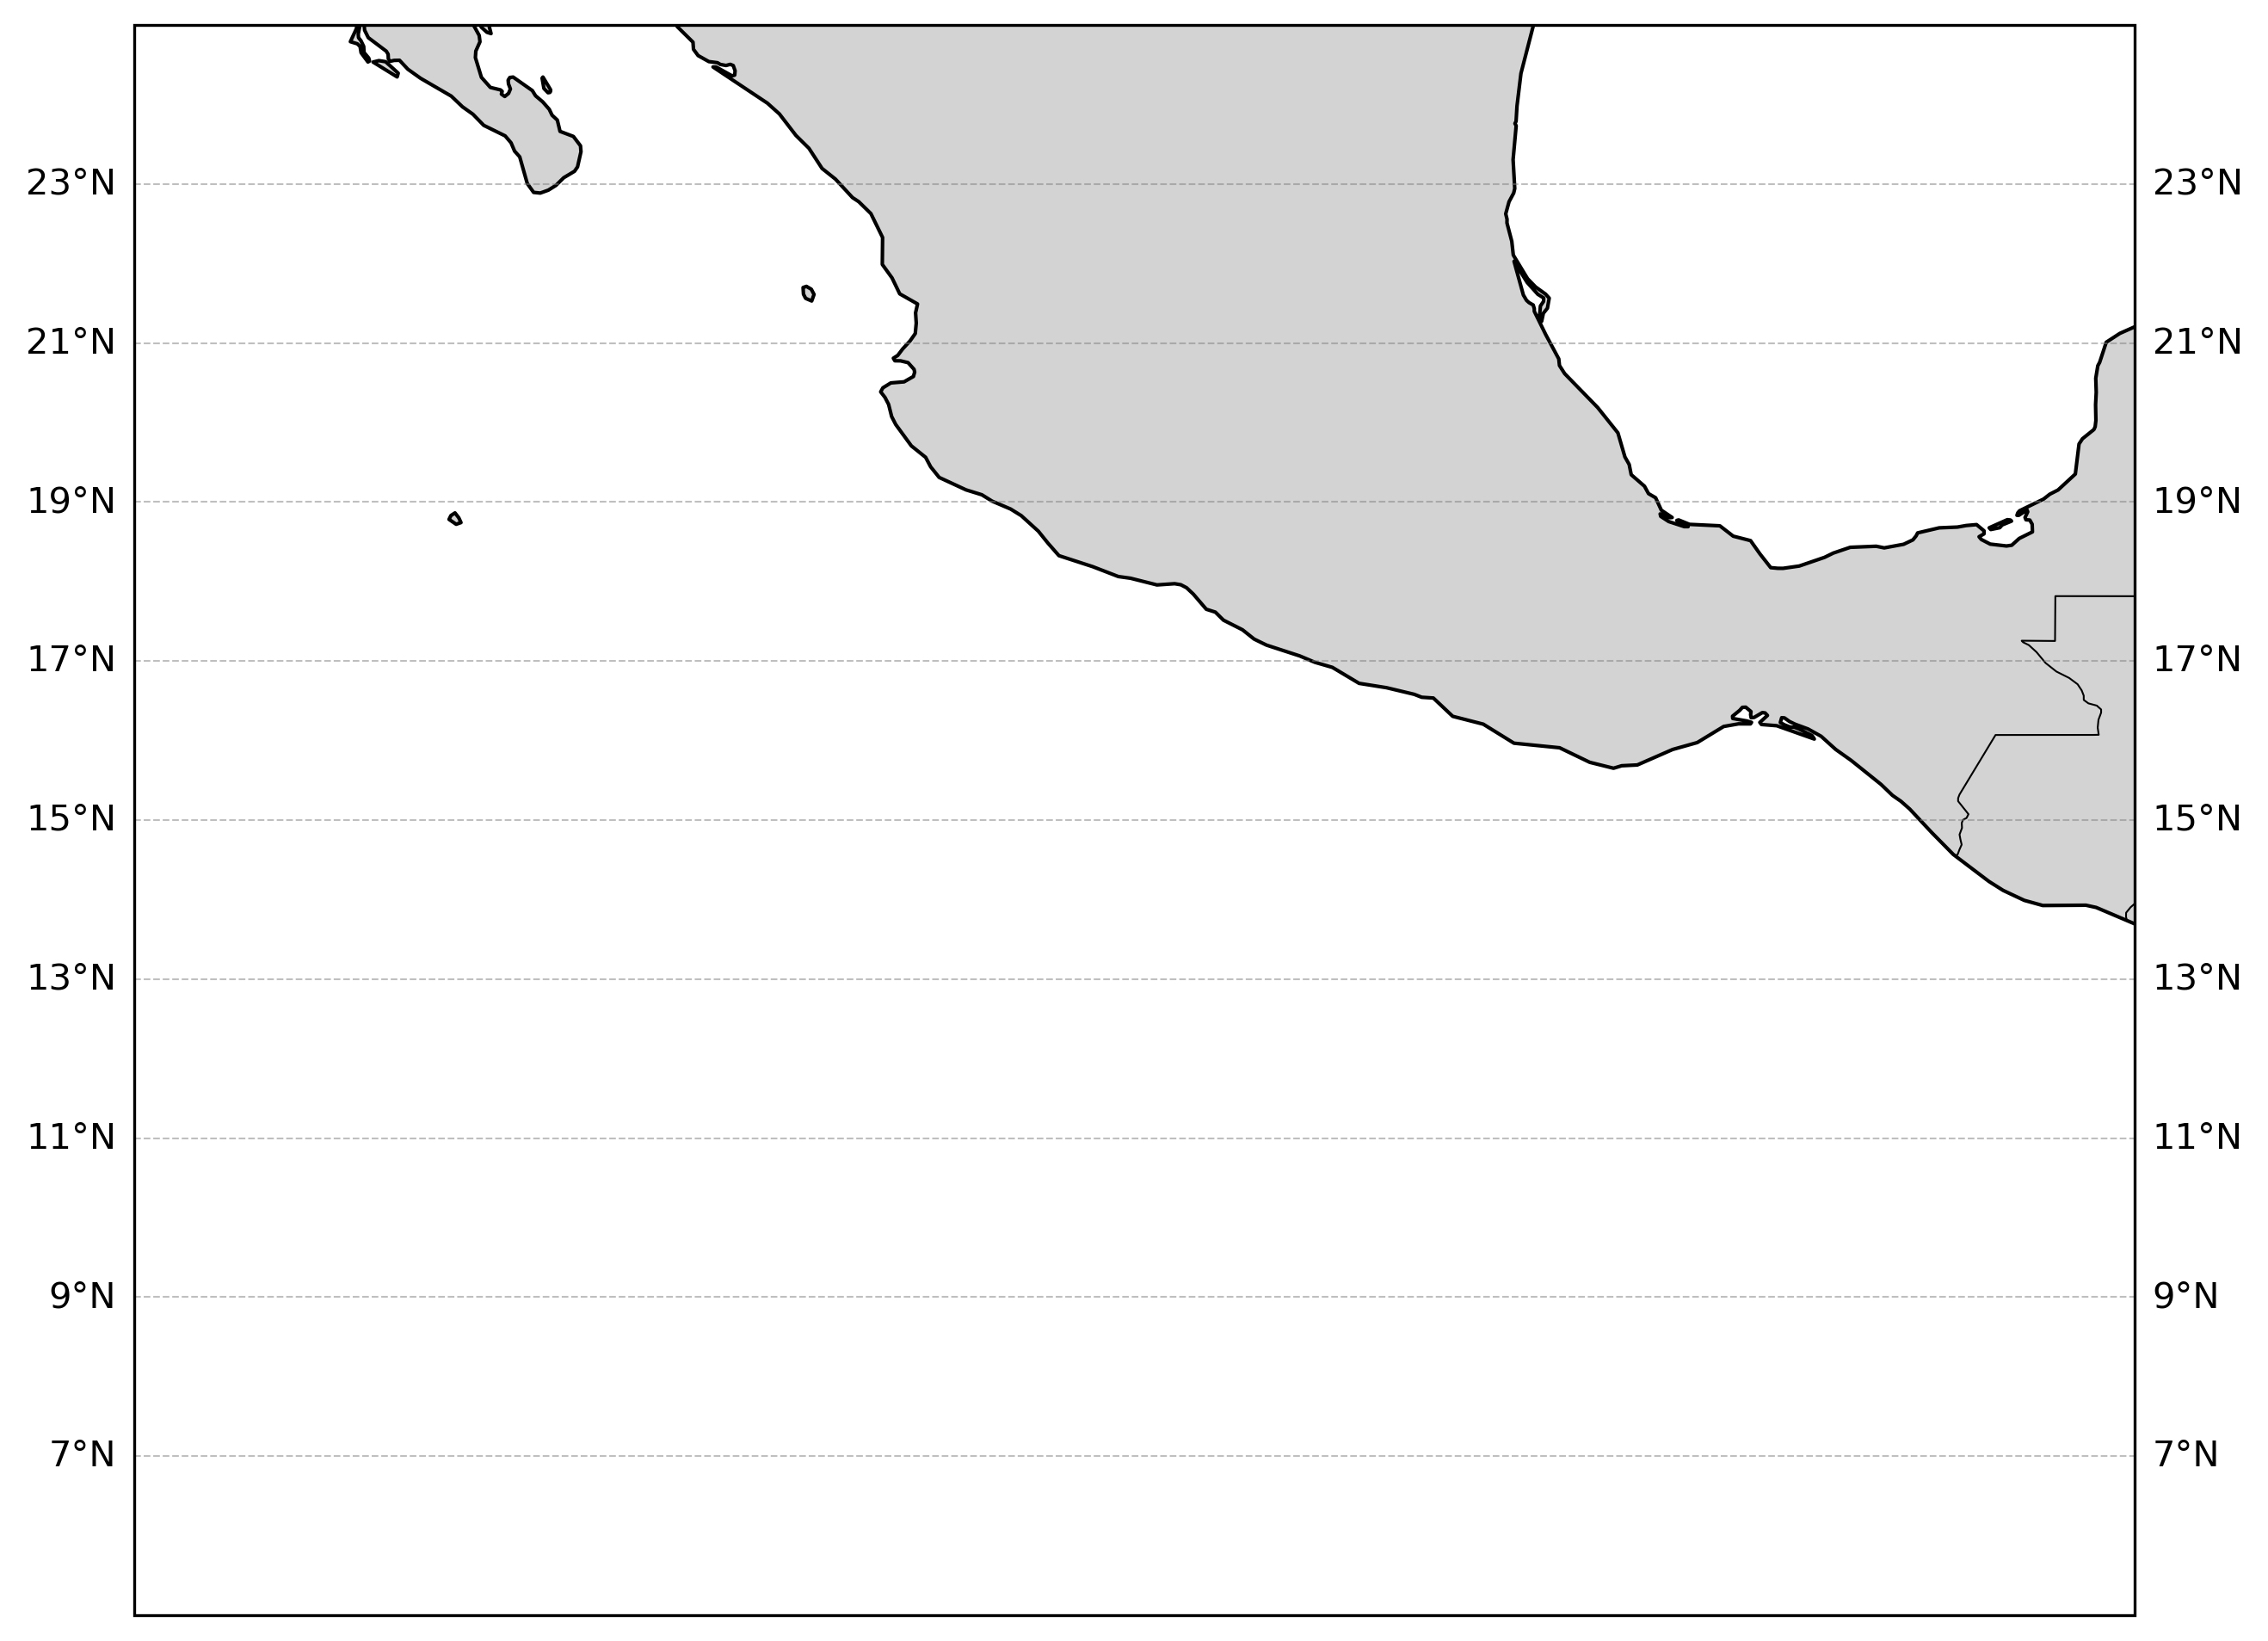

In [44]:
magU = np.sqrt(vel['UVEL'][0, 0, :, :]**2 + vel['VVEL'][0, 0, :, :]**2)
fig, ax = plt.subplots(
    figsize=(10, 8), dpi=300, facecolor='white',
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent([-115, -90, 5, 25], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")
ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5,
    linestyle='--',
    xlocs=np.arange(-90, -70, 2),
    ylocs=np.arange(5, 25, 2)
)
ax.imshow(
    magU,
    cmap=cmocean.cm.speed,
    aspect='auto'
)

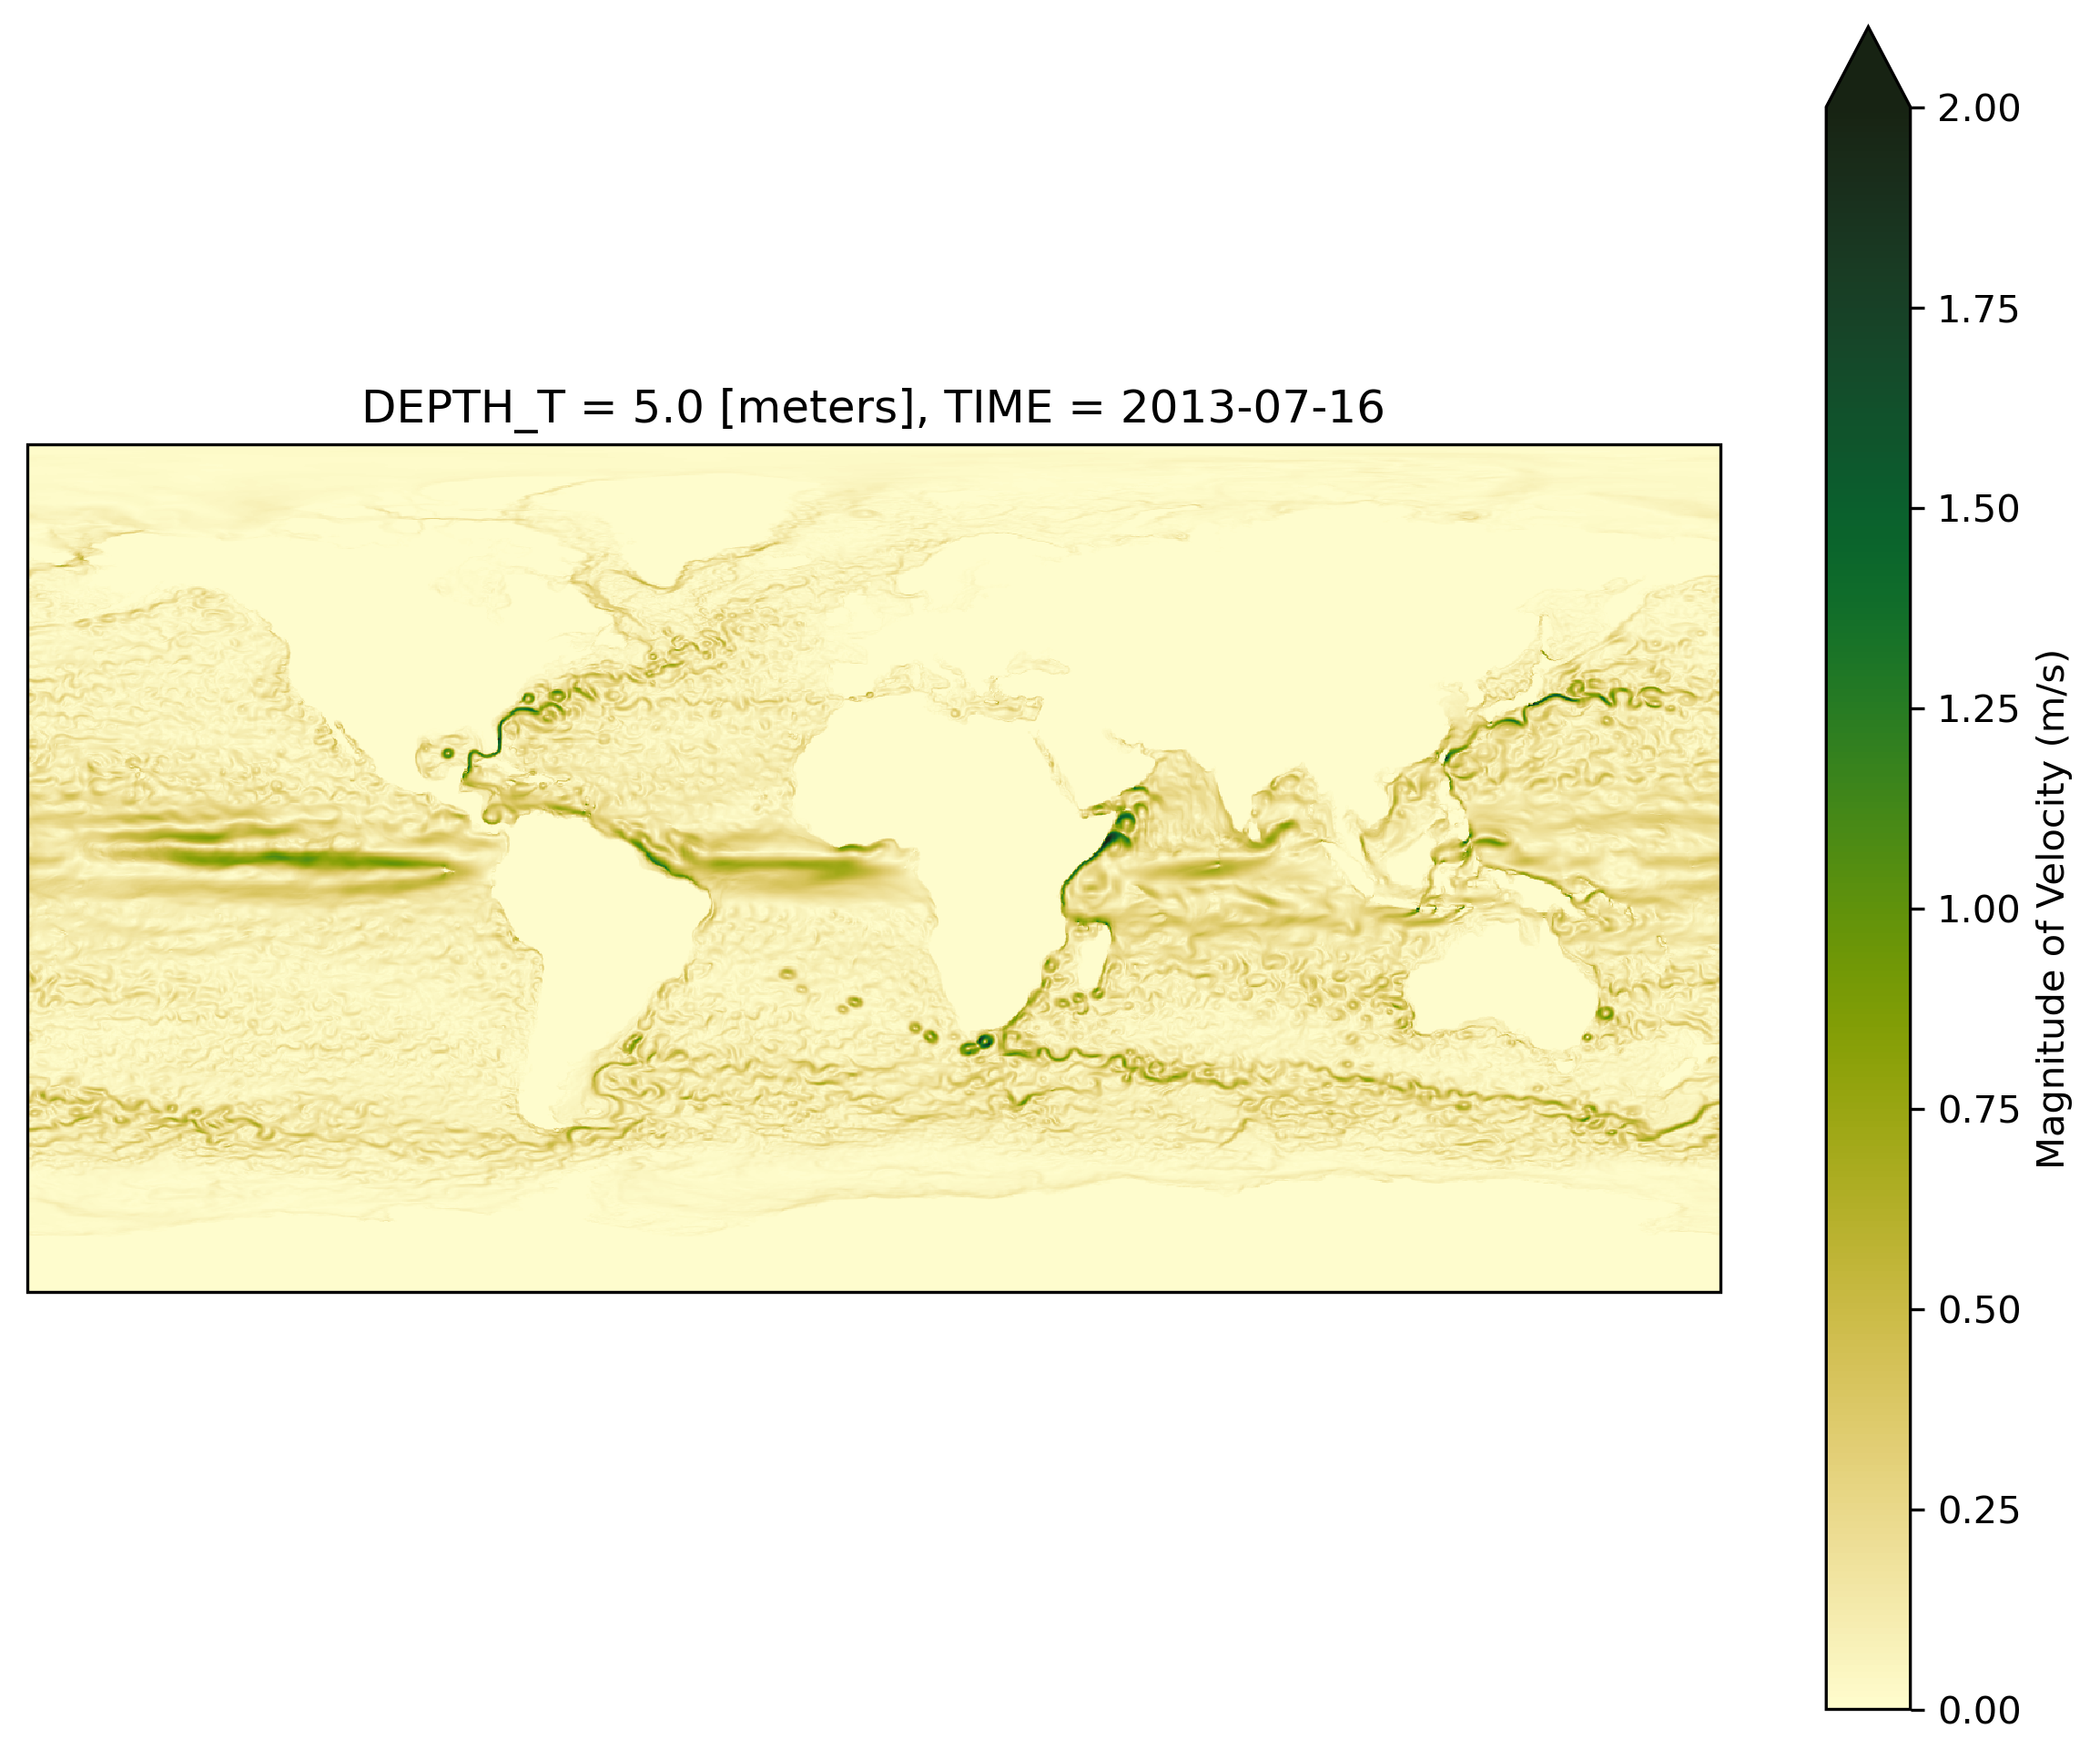

In [21]:
magU = np.sqrt(uvel['UVEL'][0, 0, :, :]**2 + vvel['VVEL'][0, 0, :, :]**2)
fig, ax = plt.subplots(
    figsize=(10, 8), dpi=300, facecolor='white',
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}
)
magU.plot.imshow(
    cmap=cmocean.cm.speed, vmin=0, vmax=2,
    cbar_kwargs={'label': 'Magnitude of Velocity (m/s)'},
    ax=ax
)


In [79]:
longAnticyclone = xr.open_dataset(
    "../data/META3.2_DT_allsat/META3.2_DT_allsat_Anticyclonic_long_19930101_20220209.nc"
)
longCyclones = xr.open_dataset(
    "../data/META3.2_DT_allsat/META3.2_DT_allsat_Cyclonic_long_19930101_20220209.nc"
)

In [82]:
longCyclones.set_coords("track")

<xarray.Dataset> Size: 33GB
Dimensions:                        (obs: 36522562, NbSample: 20)
Coordinates:
    track                          (obs) uint32 146MB ...
Dimensions without coordinates: obs, NbSample
Data variables: (12/27)
    amplitude                      (obs) float64 292MB ...
    cost_association               (obs) float32 146MB ...
    effective_area                 (obs) float32 146MB ...
    effective_contour_height       (obs) float32 146MB ...
    effective_contour_latitude     (obs, NbSample) float64 6GB ...
    effective_contour_longitude    (obs, NbSample) float64 6GB ...
    ...                             ...
    speed_contour_latitude         (obs, NbSample) float64 6GB ...
    speed_contour_longitude        (obs, NbSample) float64 6GB ...
    speed_contour_shape_error      (obs) float64 292MB ...
    speed_radius                   (obs) float64 292MB ...
    time                           (obs) datetime64[ns] 292MB ...
    uavg_profile                   (obs, NbSample) float64 6GB ...
Attributes: (12/13)
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Cyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    ...                        ...
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T23:14:21Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [83]:
longCyclones.sel(
    track=770427,
    drop=True
)

KeyError: "'track' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'obs': 36522562, 'NbSample': 20})"

In [85]:
climatology = xr.open_dataset(
    "../data/ARGO_RG2019_Climatology/subsetClimatology/RG_ArgoClim_ETP_computed_gradients.nc"
)

In [86]:
climatology

<xarray.Dataset> Size: 139MB
Dimensions:         (LONGITUDE: 23, LATITUDE: 19, PRESSURE: 58, TIME: 228)
Coordinates:
  * LONGITUDE       (LONGITUDE) float32 92B 245.5 246.5 247.5 ... 266.5 267.5
  * LATITUDE        (LATITUDE) float32 76B 5.5 6.5 7.5 8.5 ... 21.5 22.5 23.5
  * PRESSURE        (PRESSURE) float32 232B 2.5 10.0 20.0 ... 1.9e+03 1.975e+03
  * TIME            (TIME) datetime64[ns] 2kB 2004-01-01 ... 2022-12-01
Data variables:
    SA              (PRESSURE, LATITUDE, LONGITUDE, TIME) float64 46MB ...
    sigma0          (PRESSURE, LATITUDE, LONGITUDE, TIME) float64 46MB ...
    zonalFlag       (LATITUDE, LONGITUDE) float64 3kB ...
    meridionalFlag  (LATITUDE, LONGITUDE) float64 3kB ...
    gradient        (PRESSURE, LATITUDE, LONGITUDE, TIME) float64 46MB ...